In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
import matplotlib.dates as mdates
from lightgbm import LGBMRegressor
from sklearn.ensemble import ExtraTreesRegressor
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
# 全局参数
initial_funds = 100000
transaction_fee_rate = 0.0003
points_per_day = 1440
points_per_year = points_per_day * 365

In [3]:
def read_data(file_path):
    """
    读取训练、验证或测试数据并分离特征和目标值，同时检查和处理无效值。
    """
    data = pd.read_csv(file_path)
    
    # 检查和处理无效值
    if data.isna().sum().sum() > 0:
        print(f"Missing values found in {file_path}. Filling with column mean.")
        data = data.fillna(data.mean())

    if np.isinf(data.values).any():
        print(f"Infinite values found in {file_path}. Replacing with finite maximum.")
        data = data.replace([np.inf, -np.inf], np.nan)
        data = data.fillna(data.mean())
    
    X = data.drop(columns=['target']).values
    y = data['target'].values
    return X, y

def evaluate_model(y_true, y_pred, model_name):
    """
    评估模型性能。
    """
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    correlation = np.corrcoef(y_true, y_pred)[0, 1]
    print(f"{model_name} Performance:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R^2 Score: {r2:.4f}")
    print(f"Correlation Coefficient: {correlation:.4f}")
    print("-" * 30)

In [4]:
def trade_strategy(y_pred, y_test, upper_percentile, train_val_pred):
    """
    单一上阈值交易策略，避免未来数据泄露。
    
    Args:
        y_pred: 当前测试集的预测值。
        y_test: 当前测试集的真实收益率。
        upper_percentile: 分位数阈值。
        train_val_pred: 训练集和验证集的预测值，用于计算阈值。
        
    Returns:
        funds_over_time: 每个时间点的资金变化。
        trade_count: 总交易次数。
    """
    # 使用训练集和验证集的预测值计算分位数阈值
    upper_threshold = np.percentile(train_val_pred, upper_percentile)
    
    funds = initial_funds
    funds_over_time = []
    total_fees = 0.0
    total_volume = 0.0
    trade_count = 0
    previous_allocation = 0.0

    for i, pred in enumerate(y_pred):
        actual_return = y_test[i]

        # 仓位逻辑
        allocation = 1.0 if pred > upper_threshold else 0.0

        # 处理仓位变更
        if allocation != previous_allocation:
            trade_amount = funds * abs(allocation - previous_allocation)
            fee = trade_amount * transaction_fee_rate
            total_fees += fee
            funds -= fee
            total_volume += trade_amount
            trade_count += 1

        # 持仓收益
        if allocation == 1.0:
            funds *= (1 + actual_return)

        funds_over_time.append(funds)
        previous_allocation = allocation

    return funds_over_time, trade_count

In [5]:
def process_folder(folder_path, data_folder):
    """
    处理指定文件夹中的数据，训练模型并运行策略。
    返回生成的图表对象，以及预测值和真实值。
    """
    # 从文件夹名称中提取 symbol
    symbol = os.path.basename(folder_path)  # 文件夹名即 symbol
    print(f"Processing folder: {folder_path} ({symbol})")

    # 文件路径
    train_file = os.path.join(folder_path, f"Xy_train_{symbol}.csv")
    val_file = os.path.join(folder_path, f"Xy_val_{symbol}.csv")
    test_file = os.path.join(folder_path, f"Xy_test_{symbol}.csv")
    
    # 原始数据文件路径 (用于提取日期)
    original_data_file = os.path.join(data_folder, f"{symbol}_1m_ta.csv")

    # 读取数据
    X_train, y_train = read_data(train_file)
    X_val, y_val = read_data(val_file)
    X_test, y_test = read_data(test_file)

    # 定义模型
    models = {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(alpha=1.0),
        "XGBoost": XGBRegressor(),
        "LightGBM": LGBMRegressor(),
    }

    # 训练和评估
    predictions = {}
    for model_name, model in models.items():
        print(f"Training {model_name}...")

        # 检查训练数据是否包含无效值
        if np.isnan(X_train).any() or np.isinf(X_train).any():
            print(f"Invalid values found in X_train for {model_name}. Fixing...")
            X_train = np.nan_to_num(X_train, nan=np.nanmean(X_train), posinf=np.nanmax(X_train), neginf=np.nanmin(X_train))
        if np.isnan(y_train).any() or np.isinf(y_train).any():
            print(f"Invalid values found in y_train for {model_name}. Fixing...")
            y_train = np.nan_to_num(y_train, nan=np.nanmean(y_train), posinf=np.nanmax(y_train), neginf=np.nanmin(y_train))
        
        # 训练模型
        model.fit(X_train, y_train)

        # 生成训练集和验证集的预测值
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        # 合并训练集和验证集的预测值，用于计算分位数
        train_val_pred = np.concatenate([y_train_pred, y_val_pred])

        # 测试集预测
        y_test_pred = model.predict(X_test)
        predictions[model_name] = y_test_pred

        # 性能评估
        evaluate_model(y_test, y_test_pred, model_name)

        # 调用 trade_strategy
        upper_percentiles = np.arange(100.0, 95, -0.1)
        best_strategy = None
        best_return = -float('inf')

        for upper_percentile in upper_percentiles:
            funds_over_time, trade_count = trade_strategy(y_test_pred, y_test, upper_percentile, train_val_pred)
            final_funds = funds_over_time[-1]
            annualized_return = (final_funds - initial_funds) / initial_funds * (points_per_year / len(y_test_pred))

            if annualized_return > best_return:
                best_return = annualized_return
                best_strategy = {
                    "funds_over_time": funds_over_time,
                    "annualized_return": annualized_return,
                }

    # 从原始数据文件中提取日期
    df_original = pd.read_csv(original_data_file)
    num_points = len(y_test)
    dates = pd.to_datetime(df_original['date'].iloc[-num_points:])

    fig, ax = plt.subplots(figsize=(10, 6))

    # 调整指标文本在右上角的垂直位置
    text_y_positions = [0.95, 0.8, 0.65, 0.5]  # 每个模型的文本位置依次递减

    for idx, (model_name, y_test_pred) in enumerate(predictions.items()):
        # 策略优化
        upper_percentiles = np.arange(100.0, 95, -0.1)
        best_strategy = None
        best_return = -float('inf')

        for upper_percentile in upper_percentiles:
            # 修改：将 train_val_pred 传递给 trade_strategy
            funds_over_time, trade_count = trade_strategy(y_test_pred, y_test, upper_percentile, train_val_pred)
            final_funds = funds_over_time[-1]
            total_fees = trade_count * transaction_fee_rate * initial_funds
            annualized_return = (final_funds - initial_funds) / initial_funds * (points_per_year / len(y_test_pred))
            max_drawdown = np.max(1 - np.array(funds_over_time) / np.maximum.accumulate(funds_over_time))
            daily_trade_count = trade_count / (len(y_test_pred) / points_per_day)
            sharpe_ratio = (
                np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))
                * np.sqrt(points_per_year)
            )

            if annualized_return > best_return:
                best_return = annualized_return
                best_strategy = {
                    "funds_over_time": funds_over_time,
                    "upper_percentile": upper_percentile,
                    "annualized_return": annualized_return,
                    "max_drawdown": max_drawdown,
                    "daily_trade_count": daily_trade_count,
                    "total_fees": total_fees,
                    "sharpe_ratio": sharpe_ratio,
                }

        # 绘图
        print(f"Best Strategy for {symbol} ({model_name}):")
        print(f"Upper Percentile: {best_strategy['upper_percentile']}")
        print(f"Annualized Return: {best_strategy['annualized_return']:.4%}")
        print(f"Max Drawdown: {best_strategy['max_drawdown']:.4%}")
        print(f"Avg Daily Trades: {best_strategy['daily_trade_count']:.2f}")
        print(f"Total Fees: {best_strategy['total_fees']:.2f}")
        print(f"Sharpe Ratio: {best_strategy['sharpe_ratio']:.2f}")
        
        funds_over_time = best_strategy["funds_over_time"]
        ax.plot(dates, funds_over_time, label=f"{model_name} (Return: {best_strategy['annualized_return']:.2%})")

        # 在图上显示指标，每个模型文本放置在不同的垂直位置
        metrics_text = (
            f"Model: {model_name}\n"
            f"Upper Percentile: {best_strategy['upper_percentile']:.1f}\n"
            f"Annualized Return: {best_strategy['annualized_return']:.4%}\n"
            f"Max Drawdown: {best_strategy['max_drawdown']:.4%}\n"
            f"Avg Daily Trades: {best_strategy['daily_trade_count']:.2f}\n"
            f"Total Fees: {best_strategy['total_fees']:.2f}\n"
            f"Sharpe Ratio: {best_strategy['sharpe_ratio']:.2f}"
        )

        ax.text(
            0.98, text_y_positions[idx], metrics_text,
            transform=ax.transAxes,
            fontsize=8,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.6)
        )

    ax.axhline(initial_funds, color="gray", linestyle="--", label="Initial Funds")
    ax.set_title(f"Funds Over Time - {symbol}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Funds")
    ax.legend(fontsize=8, loc="upper left")
    ax.grid()
    plt.tight_layout()
    
    return fig,predictions, y_test  # 返回生成的图表对象



def process_all_folders(base_dir, data_folder, output_pdf="output.pdf", initial_funds=10000, points_per_day=1440, transaction_fee_rate=0.001):
    """
    遍历所有文件夹并处理数据，将生成的图表保存到单一 PDF 文件。
    同时生成所有币对最佳模型的平均 PnL 图。
    """
    y_preds_by_pair = {}
    y_tests_by_pair = {}

    with PdfPages(output_pdf) as pdf:
        for folder_name in tqdm(os.listdir(base_dir), desc="Processing folders"):
            folder_path = os.path.join(base_dir, folder_name)
            if os.path.isdir(folder_path):
                # Process folder and get predictions
                fig, predictions, y_test = process_folder(folder_path, data_folder)
                
                # 保存预测值和真实值
                symbol = os.path.basename(folder_path)  # 提取币对名
                y_preds_by_pair[symbol] = predictions
                y_tests_by_pair[symbol] = y_test

                # 保存图表到 PDF 文件
                if fig is not None:
                    pdf.savefig(fig)  # 确保这里传递的是 Figure 对象

    print(f"All charts saved to {output_pdf}")

    # 调用函数绘制平均 PnL 图
    thresholds = np.arange(100.0, 95.0, -0.1)  # 设定阈值范围
    plot_average_pnl_best_models_last_points(
        y_preds_by_pair=y_preds_by_pair,
        y_tests_by_pair=y_tests_by_pair,
        data_folder = data_folder,
        thresholds=thresholds,
        initial_funds=initial_funds,
        points_per_day=points_per_day,
        transaction_fee_rate=transaction_fee_rate
    )

def plot_average_pnl_best_models_last_points(
    y_preds_by_pair, 
    y_tests_by_pair, 
    thresholds, 
    data_folder,                
    initial_funds=100000, 
    points_per_day=1440, 
    last_points=50000
):
    """
    对各币对进行“最佳模型”筛选后，绘制最后 last_points 个点的平均PnL图(带日期).
    如果某些币对的曲线不足最长曲线的长度，直接补0再计算平均值。
    输出尽量简洁，避免在控制台打印大段信息。
    """
    if not y_preds_by_pair or not y_tests_by_pair:
        print("No valid data to process.")
        return

    best_model_pnl_over_time = []    # 用来存储各币对“最佳资金曲线”的末尾部分
    dates_dict = {}                  # 用来存储各币对对应的日期索引（末尾部分）

    # 这里假设一年总点数（points_per_year）由你自行定义：
    # 如果是按1分钟粒度，一天1440个点，一年大约365天，那么:
    points_per_year = points_per_day * 365

    reference_pair_name = None

    for idx, (pair_name, y_preds) in enumerate(y_preds_by_pair.items()):
        y_test = y_tests_by_pair.get(pair_name, None)
        if y_test is None or len(y_test) == 0:
            continue

        # ---------- 读取原始CSV，拿到日期列 ----------
        original_data_file = os.path.join(data_folder, f"{pair_name}_1m_ta.csv")
        if not os.path.isfile(original_data_file):
            print(f"CSV not found for {pair_name}, skip.")
            continue

        df_original = pd.read_csv(original_data_file)
        num_points = len(y_test)
        pair_dates_all = pd.to_datetime(df_original['date'].iloc[-num_points:])

        best_annualized_return = -float('inf')
        best_funds_over_time = None

        for model_name, y_pred in y_preds.items():
            for up in thresholds:
                funds_over_time, trade_count = trade_strategy(
                    y_pred, 
                    y_test, 
                    up, 
                    y_pred
                )
                final_funds = funds_over_time[-1]
                annual_return = (
                    (final_funds - initial_funds) / initial_funds
                ) * (
                    points_per_year / len(y_pred)
                )

                if annual_return > best_annualized_return:
                    best_annualized_return = annual_return
                    best_funds_over_time = funds_over_time

        if best_funds_over_time is not None:
            if len(best_funds_over_time) > last_points:
                best_funds_over_time = best_funds_over_time[-last_points:]
                pair_dates = pair_dates_all[-last_points:]
            else:
                pair_dates = pair_dates_all[-len(best_funds_over_time):]

            best_model_pnl_over_time.append(best_funds_over_time)
            dates_dict[pair_name] = pair_dates

        if reference_pair_name is None and pair_name in dates_dict:
            reference_pair_name = pair_name

    if len(best_model_pnl_over_time) == 0 or reference_pair_name is None:
        print("No valid PnL data to plot.")
        return

    max_len = max(len(curve) for curve in best_model_pnl_over_time)
    aligned_curves = [
        np.pad(curve, (max_len - len(curve), 0), 'constant', constant_values=0)
        for curve in best_model_pnl_over_time
    ]
    average_pnl = np.mean(aligned_curves, axis=0)

    ref_dates = dates_dict[reference_pair_name]
    if len(ref_dates) < max_len:
        ref_dates = pd.date_range(start=ref_dates[0] - pd.Timedelta(minutes=(max_len - len(ref_dates))), periods=max_len, freq='1T')

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(ref_dates, average_pnl, label=f"Avg PnL (Last {max_len} pts) across {len(aligned_curves)} pairs")

    ax.axhline(initial_funds, color="gray", linestyle="--", label="Initial Funds")
    ax.set_title("Average PnL Over Time - Best Models (last_points)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Funds")
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()





In [6]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


In [14]:
base_dir ="./processed"
data_folder="./data"
process_all_folders(
    base_dir=base_dir,
    data_folder=data_folder,
    initial_funds=100000,
    points_per_day=1440,
    transaction_fee_rate=0.0003
)

Processing folders:   0%|          | 0/109 [00:00<?, ?it/s]

Processing folder: ./processed\1000SATSUSDT (1000SATSUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0002
Correlation Coefficient: 0.0239
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: 0.0007
Correlation Coefficient: 0.0275
------------------------------


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.64442e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0475
Correlation Coefficient: 0.0422
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6471
[LightGBM] [Info] Number of data points in the train set: 375311, number of used features: 31
[LightGBM] [Info] Start training from score 0.000000
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0042
Correlation Coefficient: 0.0244
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for 1000SATSUSDT (Linear Regression):
Upper Percentile: 99.00000000000006
Annualized Return: 62.2017%
Max Drawdown: 5.6755%
Avg Daily Trades: 1.65
Total Fees: 2760.00
Sharpe Ratio: 3.55
Best Strategy for 1000SATSUSDT (Ridge Regression):
Upper Percentile: 97.60000000000014
Annualized Return: 86.4563%
Max Drawdown: 9.9384%
Avg Daily Trades: 10.28
Total Fees: 17220.00
Sharpe Ratio: 2.94
Best Strategy for 1000SATSUSDT (XGBoost):
Upper Percentile: 99.9
Annualized Return: 25.5310%
Max Drawdown: 5.2283%
Avg Daily Trades: 5.19
Total Fees: 8700.00
Sharpe Ratio: 1.43
Best Strategy for 1000SATSUSDT (LightGBM):
Upper Percentile: 99.60000000000002
Annualized Return: 36.2670%
Max Drawdown: 6.7237%
Avg Daily Trades: 2.47
Total Fees: 4140.00
Sharpe Ratio: 2.07


Processing folders:   1%|          | 1/109 [00:22<40:57, 22.75s/it]

Processing folder: ./processed\1MBABYDOGEUSDT (1MBABYDOGEUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0021
R^2 Score: -0.0070
Correlation Coefficient: 0.0258
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0021
R^2 Score: 0.0024
Correlation Coefficient: 0.0500
------------------------------


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.04097e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0024
R^2 Score: -0.3442
Correlation Coefficient: -0.0153
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6726
[LightGBM] [Info] Number of data points in the train set: 95970, number of used features: 32
[LightGBM] [Info] Start training from score 0.000004
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0021
R^2 Score: -0.0653
Correlation Coefficient: -0.0078
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for 1MBABYDOGEUSDT (Linear Regression):
Upper Percentile: 95.40000000000026
Annualized Return: 1255.1584%
Max Drawdown: 22.6682%
Avg Daily Trades: 54.62
Total Fees: 23400.00
Sharpe Ratio: 7.61
Best Strategy for 1MBABYDOGEUSDT (Ridge Regression):
Upper Percentile: 97.30000000000015
Annualized Return: 1591.5200%
Max Drawdown: 11.9275%
Avg Daily Trades: 27.17
Total Fees: 11640.00
Sharpe Ratio: 11.94
Best Strategy for 1MBABYDOGEUSDT (XGBoost):
Upper Percentile: 99.9
Annualized Return: 250.1786%
Max Drawdown: 3.5201%
Avg Daily Trades: 12.32
Total Fees: 5280.00
Sharpe Ratio: 7.25


Processing folders:   2%|▏         | 2/109 [00:29<23:21, 13.10s/it]

Best Strategy for 1MBABYDOGEUSDT (LightGBM):
Upper Percentile: 99.50000000000003
Annualized Return: 160.9309%
Max Drawdown: 11.7351%
Avg Daily Trades: 20.31
Total Fees: 8700.00
Sharpe Ratio: 2.66
Processing folder: ./processed\AAVEUSDT (AAVEUSDT)
Infinite values found in ./processed\AAVEUSDT\Xy_train_AAVEUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0036
Correlation Coefficient: 0.0095
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.86669e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0035
Correlation Coefficient: 0.0095
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0758
Correlation Coefficient: 0.0093
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6214
[LightGBM] [Info] Number of data points in the train set: 1460806, number of used features: 29
[LightGBM] [Info] Start training from score 0.000001
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0009
Correlation Coefficient: 0.0263
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for AAVEUSDT (Linear Regression):
Upper Percentile: 99.60000000000002
Annualized Return: 30.6669%
Max Drawdown: 3.7894%
Avg Daily Trades: 0.22
Total Fees: 1440.00
Sharpe Ratio: 2.80
Best Strategy for AAVEUSDT (Ridge Regression):
Upper Percentile: 99.50000000000003
Annualized Return: 38.6030%
Max Drawdown: 3.9913%
Avg Daily Trades: 0.27
Total Fees: 1740.00
Sharpe Ratio: 3.11
Best Strategy for AAVEUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for AAVEUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 16.3574%
Max Drawdown: 6.4201%
Avg Daily Trades: 0.56
Total Fees: 3660.00
Sharpe Ratio: 1.15


Processing folders:   3%|▎         | 3/109 [01:58<1:24:50, 48.02s/it]

Processing folder: ./processed\ACEUSDT (ACEUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0023
Correlation Coefficient: -0.0058
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0021
Correlation Coefficient: -0.0057
------------------------------


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=4.27997e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0456
Correlation Coefficient: 0.0120
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6199
[LightGBM] [Info] Number of data points in the train set: 370126, number of used features: 28
[LightGBM] [Info] Start training from score -0.000003
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0044
Correlation Coefficient: 0.0136
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for ACEUSDT (Linear Regression):
Upper Percentile: 99.80000000000001
Annualized Return: 7.5344%
Max Drawdown: 0.0300%
Avg Daily Trades: 0.07
Total Fees: 120.00
Sharpe Ratio: 2.79
Best Strategy for ACEUSDT (Ridge Regression):
Upper Percentile: 99.80000000000001
Annualized Return: 1.7472%
Max Drawdown: 0.0300%
Avg Daily Trades: 0.07
Total Fees: 120.00
Sharpe Ratio: 2.91
Best Strategy for ACEUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for ACEUSDT (LightGBM):
Upper Percentile: 99.80000000000001
Annualized Return: 18.1458%
Max Drawdown: 3.0572%
Avg Daily Trades: 0.84
Total Fees: 1380.00
Sharpe Ratio: 1.54


Processing folders:   4%|▎         | 4/109 [02:19<1:05:25, 37.39s/it]

Processing folder: ./processed\ADAUSDT (ADAUSDT)
Infinite values found in ./processed\ADAUSDT\Xy_train_ADAUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0008
R^2 Score: -0.0005
Correlation Coefficient: 0.0192
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.85927e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0008
R^2 Score: -0.0005
Correlation Coefficient: 0.0177
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0008
R^2 Score: -0.0712
Correlation Coefficient: 0.0182
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5959
[LightGBM] [Info] Number of data points in the train set: 1459000, number of used features: 28
[LightGBM] [Info] Start training from score 0.000001
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0008
R^2 Score: -0.0040
Correlation Coefficient: 0.0197
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for ADAUSDT (Linear Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 43.5826%
Max Drawdown: 3.2612%
Avg Daily Trades: 0.20
Total Fees: 1320.00
Sharpe Ratio: 3.58
Best Strategy for ADAUSDT (Ridge Regression):
Upper Percentile: 99.80000000000001
Annualized Return: 43.9420%
Max Drawdown: 1.0438%
Avg Daily Trades: 0.08
Total Fees: 540.00
Sharpe Ratio: 4.05
Best Strategy for ADAUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for ADAUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 14.2271%
Max Drawdown: 5.9978%
Avg Daily Trades: 0.54
Total Fees: 3540.00
Sharpe Ratio: 1.11


Processing folders:   5%|▍         | 5/109 [03:45<1:35:09, 54.90s/it]

Processing folder: ./processed\AEVOUSDT (AEVOUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0734
Correlation Coefficient: 0.0073
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0736
Correlation Coefficient: 0.0097
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0552
Correlation Coefficient: 0.0182
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6188
[LightGBM] [Info] Number of data points in the train set: 283962, number of used features: 30
[LightGBM] [Info] Start traini

C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for AEVOUSDT (Linear Regression):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for AEVOUSDT (Ridge Regression):
Upper Percentile: 99.80000000000001
Annualized Return: 7.4826%
Max Drawdown: 0.0300%
Avg Daily Trades: 0.05
Total Fees: 60.00
Sharpe Ratio: 2.84
Best Strategy for AEVOUSDT (XGBoost):
Upper Percentile: 98.3000000000001
Annualized Return: 38.9270%
Max Drawdown: 1.1626%
Avg Daily Trades: 1.75
Total Fees: 2220.00
Sharpe Ratio: 4.08
Best Strategy for AEVOUSDT (LightGBM):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan


Processing folders:   6%|▌         | 6/109 [04:03<1:12:51, 42.44s/it]

Processing folder: ./processed\AGIXUSDT (AGIXUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0016
R^2 Score: -0.0023
Correlation Coefficient: 0.0115
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0016
R^2 Score: -0.0001
Correlation Coefficient: 0.0178
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0019
R^2 Score: -0.3396
Correlation Coefficient: -0.0074
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4352
[LightGBM] [Info] Number of data points in the train set: 496733, number of used features: 20
[LightGBM] [Info] Start train

C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for AGIXUSDT (Linear Regression):
Upper Percentile: 99.20000000000005
Annualized Return: 161.1753%
Max Drawdown: 17.5688%
Avg Daily Trades: 3.95
Total Fees: 8760.00
Sharpe Ratio: 3.72
Best Strategy for AGIXUSDT (Ridge Regression):
Upper Percentile: 99.10000000000005
Annualized Return: 119.4121%
Max Drawdown: 5.3570%
Avg Daily Trades: 0.95
Total Fees: 2100.00
Sharpe Ratio: 4.43
Best Strategy for AGIXUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for AGIXUSDT (LightGBM):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan


Processing folders:   6%|▋         | 7/109 [04:40<1:09:07, 40.66s/it]

Processing folder: ./processed\AIUSDT (AIUSDT)
Infinite values found in ./processed\AIUSDT\Xy_train_AIUSDT.csv. Replacing with finite maximum.
Infinite values found in ./processed\AIUSDT\Xy_test_AIUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: 0.0048
Correlation Coefficient: 0.0756
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: 0.0042
Correlation Coefficient: 0.0709
------------------------------


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.0604e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.0284
Correlation Coefficient: 0.1043
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6724
[LightGBM] [Info] Number of data points in the train set: 352822, number of used features: 31
[LightGBM] [Info] Start training from score -0.000001
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.0007
Correlation Coefficient: 0.1098
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for AIUSDT (Linear Regression):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for AIUSDT (Ridge Regression):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for AIUSDT (XGBoost):
Upper Percentile: 99.80000000000001
Annualized Return: 36.6459%
Max Drawdown: 8.0881%
Avg Daily Trades: 4.38
Total Fees: 6900.00
Sharpe Ratio: 2.06
Best Strategy for AIUSDT (LightGBM):
Upper Percentile: 98.3000000000001
Annualized Return: 158.4077%
Max Drawdown: 18.4282%
Avg Daily Trades: 47.73
Total Fees: 75180.00
Sharpe Ratio: 5.92


Processing folders:   7%|▋         | 8/109 [05:02<58:07, 34.53s/it]  

Processing folder: ./processed\ALTUSDT (ALTUSDT)
Infinite values found in ./processed\ALTUSDT\Xy_train_ALTUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0013
R^2 Score: -0.0002
Correlation Coefficient: 0.0165
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0013
R^2 Score: 0.0001
Correlation Coefficient: 0.0175
------------------------------


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.50046e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0014
R^2 Score: -0.0578
Correlation Coefficient: 0.0147
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6444
[LightGBM] [Info] Number of data points in the train set: 331654, number of used features: 29
[LightGBM] [Info] Start training from score -0.000003
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0013
R^2 Score: -0.0017
Correlation Coefficient: 0.0390
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for ALTUSDT (Linear Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 13.5559%
Max Drawdown: 0.0300%
Avg Daily Trades: 0.04
Total Fees: 60.00
Sharpe Ratio: 2.67
Best Strategy for ALTUSDT (Ridge Regression):
Upper Percentile: 99.60000000000002
Annualized Return: 13.5559%
Max Drawdown: 0.0300%
Avg Daily Trades: 0.04
Total Fees: 60.00
Sharpe Ratio: 2.67
Best Strategy for ALTUSDT (XGBoost):
Upper Percentile: 99.80000000000001
Annualized Return: 28.8567%
Max Drawdown: 7.9499%
Avg Daily Trades: 14.31
Total Fees: 21180.00
Sharpe Ratio: 1.10
Best Strategy for ALTUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 55.8287%
Max Drawdown: 2.0482%
Avg Daily Trades: 0.57
Total Fees: 840.00
Sharpe Ratio: 4.72


Processing folders:   8%|▊         | 9/109 [05:23<50:19, 30.20s/it]

Processing folder: ./processed\APEUSDT (APEUSDT)
Infinite values found in ./processed\APEUSDT\Xy_train_APEUSDT.csv. Replacing with finite maximum.
Infinite values found in ./processed\APEUSDT\Xy_val_APEUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: 0.0023
Correlation Coefficient: 0.0553
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: 0.0022
Correlation Coefficient: 0.0550
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0488
Correlation Coefficient: 0.0067
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056043 seconds.
You can set `force_col_wis

C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for APEUSDT (Linear Regression):
Upper Percentile: 99.80000000000001
Annualized Return: 70.0156%
Max Drawdown: 1.0213%
Avg Daily Trades: 0.05
Total Fees: 240.00
Sharpe Ratio: 3.14
Best Strategy for APEUSDT (Ridge Regression):
Upper Percentile: 99.80000000000001
Annualized Return: 61.1825%
Max Drawdown: 3.6117%
Avg Daily Trades: 0.07
Total Fees: 300.00
Sharpe Ratio: 2.72
Best Strategy for APEUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 27.3112%
Max Drawdown: 0.0300%
Avg Daily Trades: 0.01
Total Fees: 60.00
Sharpe Ratio: 1.55
Best Strategy for APEUSDT (LightGBM):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan


Processing folders:   9%|▉         | 10/109 [06:22<1:04:43, 39.23s/it]

Processing folder: ./processed\API3USDT (API3USDT)
Infinite values found in ./processed\API3USDT\Xy_train_API3USDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: 0.0002
Correlation Coefficient: 0.0157
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: 0.0001
Correlation Coefficient: 0.0152
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0206
Correlation Coefficient: 0.0256
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6150
[LightGBM] [Info] Number o

C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for API3USDT (Linear Regression):
Upper Percentile: 99.80000000000001
Annualized Return: 49.2835%
Max Drawdown: 1.9773%
Avg Daily Trades: 0.05
Total Fees: 240.00
Sharpe Ratio: 3.08
Best Strategy for API3USDT (Ridge Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 79.4276%
Max Drawdown: 6.1558%
Avg Daily Trades: 0.14
Total Fees: 660.00
Sharpe Ratio: 3.37
Best Strategy for API3USDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for API3USDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 4.6202%
Max Drawdown: 7.0122%
Avg Daily Trades: 0.64
Total Fees: 3060.00
Sharpe Ratio: 0.32


Processing folders:  10%|█         | 11/109 [07:26<1:16:39, 46.93s/it]

Processing folder: ./processed\APTUSDT (APTUSDT)
Infinite values found in ./processed\APTUSDT\Xy_train_APTUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: 0.0013
Correlation Coefficient: 0.0441
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.90376e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: 0.0013
Correlation Coefficient: 0.0420
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.3685
Correlation Coefficient: 0.0165
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5880
[LightGBM] [Info] Number of data points in the train set: 798680, number of used features: 25
[LightGBM] [Info] Start training from score 0.000001
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0015
Correlation Coefficient: 0.0282
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for APTUSDT (Linear Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 38.7509%
Max Drawdown: 5.1190%
Avg Daily Trades: 0.13
Total Fees: 480.00
Sharpe Ratio: 2.95
Best Strategy for APTUSDT (Ridge Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 39.7917%
Max Drawdown: 5.1190%
Avg Daily Trades: 0.10
Total Fees: 360.00
Sharpe Ratio: 3.01
Best Strategy for APTUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for APTUSDT (LightGBM):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan


Processing folders:  11%|█         | 12/109 [08:12<1:15:17, 46.57s/it]

Processing folder: ./processed\ARBUSDT (ARBUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0008
R^2 Score: -0.0000
Correlation Coefficient: 0.0148
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.66323e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0008
R^2 Score: 0.0002
Correlation Coefficient: 0.0189
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0008
R^2 Score: -0.0511
Correlation Coefficient: 0.0083
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6469
[LightGBM] [Info] Number of data points in the train set: 641241, number of used features: 30
[LightGBM] [Info] Start training from score 0.000000
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0008
R^2 Score: -0.0040
Correlation Coefficient: 0.0318
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for ARBUSDT (Linear Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 48.1915%
Max Drawdown: 1.0179%
Avg Daily Trades: 0.04
Total Fees: 120.00
Sharpe Ratio: 3.47
Best Strategy for ARBUSDT (Ridge Regression):
Upper Percentile: 99.80000000000001
Annualized Return: 50.5509%
Max Drawdown: 1.0179%
Avg Daily Trades: 0.06
Total Fees: 180.00
Sharpe Ratio: 3.64
Best Strategy for ARBUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for ARBUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 29.3690%
Max Drawdown: 3.3103%
Avg Daily Trades: 0.86
Total Fees: 2460.00
Sharpe Ratio: 1.88


Processing folders:  12%|█▏        | 13/109 [08:51<1:10:38, 44.15s/it]

Processing folder: ./processed\ATOMUSDT (ATOMUSDT)
Infinite values found in ./processed\ATOMUSDT\Xy_train_ATOMUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0008
R^2 Score: 0.0001
Correlation Coefficient: 0.0203
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=6.4571e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0008
R^2 Score: 0.0002
Correlation Coefficient: 0.0189
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0008
R^2 Score: -0.0651
Correlation Coefficient: 0.0057
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6135
[LightGBM] [Info] Number of data points in the train set: 1459611, number of used features: 26
[LightGBM] [Info] Start training from score 0.000002
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0008
R^2 Score: -0.0060
Correlation Coefficient: -0.0099
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for ATOMUSDT (Linear Regression):
Upper Percentile: 99.60000000000002
Annualized Return: 37.4604%
Max Drawdown: 4.9750%
Avg Daily Trades: 0.76
Total Fees: 4920.00
Sharpe Ratio: 3.66
Best Strategy for ATOMUSDT (Ridge Regression):
Upper Percentile: 99.60000000000002
Annualized Return: 29.1006%
Max Drawdown: 4.6898%
Avg Daily Trades: 0.52
Total Fees: 3360.00
Sharpe Ratio: 2.77
Best Strategy for ATOMUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for ATOMUSDT (LightGBM):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan


Processing folders:  13%|█▎        | 14/109 [10:17<1:30:13, 56.99s/it]

Processing folder: ./processed\AVAXUSDT (AVAXUSDT)
Infinite values found in ./processed\AVAXUSDT\Xy_train_AVAXUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0003
Correlation Coefficient: 0.0188
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.73289e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0002
Correlation Coefficient: 0.0191
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.3405
Correlation Coefficient: -0.0118
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6454
[LightGBM] [Info] Number of data points in the train set: 1459000, number of used features: 29
[LightGBM] [Info] Start training from score 0.000002
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0022
Correlation Coefficient: 0.0255
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for AVAXUSDT (Linear Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 63.8718%
Max Drawdown: 2.9092%
Avg Daily Trades: 0.24
Total Fees: 1560.00
Sharpe Ratio: 4.62
Best Strategy for AVAXUSDT (Ridge Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 65.8019%
Max Drawdown: 1.0840%
Avg Daily Trades: 0.18
Total Fees: 1140.00
Sharpe Ratio: 4.89
Best Strategy for AVAXUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for AVAXUSDT (LightGBM):
Upper Percentile: 99.80000000000001
Annualized Return: 14.4526%
Max Drawdown: 11.8988%
Avg Daily Trades: 1.41
Total Fees: 9180.00
Sharpe Ratio: 0.94


Processing folders:  14%|█▍        | 15/109 [11:46<1:44:16, 66.56s/it]

Processing folder: ./processed\BAKEUSDT (BAKEUSDT)
Infinite values found in ./processed\BAKEUSDT\Xy_train_BAKEUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0014
R^2 Score: -0.0022
Correlation Coefficient: 0.0097
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0014
R^2 Score: -0.0020
Correlation Coefficient: 0.0100
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0014
R^2 Score: -0.0217
Correlation Coefficient: 0.0176
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5961
[LightGBM] [Info] Number

C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for BAKEUSDT (Linear Regression):
Upper Percentile: 99.60000000000002
Annualized Return: 54.8423%
Max Drawdown: 14.4380%
Avg Daily Trades: 0.26
Total Fees: 1560.00
Sharpe Ratio: 1.54
Best Strategy for BAKEUSDT (Ridge Regression):
Upper Percentile: 99.80000000000001
Annualized Return: 70.2824%
Max Drawdown: 14.4380%
Avg Daily Trades: 0.17
Total Fees: 1020.00
Sharpe Ratio: 2.00
Best Strategy for BAKEUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for BAKEUSDT (LightGBM):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan


Processing folders:  15%|█▍        | 16/109 [13:07<1:49:54, 70.91s/it]

Processing folder: ./processed\BBUSDT (BBUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.0014
Correlation Coefficient: 0.0028
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.0004
Correlation Coefficient: 0.0074
------------------------------


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.44121e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0013
R^2 Score: -0.1277
Correlation Coefficient: 0.0163
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6456
[LightGBM] [Info] Number of data points in the train set: 222978, number of used features: 30
[LightGBM] [Info] Start training from score 0.000002
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.0027
Correlation Coefficient: 0.0365
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for BBUSDT (Linear Regression):
Upper Percentile: 99.50000000000003
Annualized Return: 42.2802%
Max Drawdown: 1.7146%
Avg Daily Trades: 0.30
Total Fees: 300.00
Sharpe Ratio: 3.28
Best Strategy for BBUSDT (Ridge Regression):
Upper Percentile: 99.20000000000005
Annualized Return: 32.9477%
Max Drawdown: 1.7146%
Avg Daily Trades: 0.18
Total Fees: 180.00
Sharpe Ratio: 2.60
Best Strategy for BBUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 57.7227%
Max Drawdown: 0.0300%
Avg Daily Trades: 0.18
Total Fees: 180.00
Sharpe Ratio: 5.00
Best Strategy for BBUSDT (LightGBM):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan


Processing folders:  16%|█▌        | 17/109 [13:20<1:22:11, 53.60s/it]

Processing folder: ./processed\BCHUSDT (BCHUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0008
R^2 Score: -0.0001
Correlation Coefficient: 0.0199
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0008
R^2 Score: 0.0001
Correlation Coefficient: 0.0219
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0008
R^2 Score: -0.0154
Correlation Coefficient: 0.0351
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5704
[LightGBM] [Info] Number of data points in the train set: 14596

C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for BCHUSDT (Linear Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 18.7271%
Max Drawdown: 12.8787%
Avg Daily Trades: 0.17
Total Fees: 1080.00
Sharpe Ratio: 1.20
Best Strategy for BCHUSDT (Ridge Regression):
Upper Percentile: 98.90000000000006
Annualized Return: 42.3327%
Max Drawdown: 17.9934%
Avg Daily Trades: 1.28
Total Fees: 8340.00
Sharpe Ratio: 1.42
Best Strategy for BCHUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for BCHUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 60.0419%
Max Drawdown: 9.3777%
Avg Daily Trades: 1.46
Total Fees: 9540.00
Sharpe Ratio: 2.48


Processing folders:  17%|█▋        | 18/109 [14:47<1:36:05, 63.36s/it]

Processing folder: ./processed\BELUSDT (BELUSDT)
Infinite values found in ./processed\BELUSDT\Xy_train_BELUSDT.csv. Replacing with finite maximum.
Infinite values found in ./processed\BELUSDT\Xy_val_BELUSDT.csv. Replacing with finite maximum.
Infinite values found in ./processed\BELUSDT\Xy_test_BELUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0027
Correlation Coefficient: 0.0136
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.55706e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0025
Correlation Coefficient: 0.0150
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.1280
Correlation Coefficient: 0.0070
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6454
[LightGBM] [Info] Number of data points in the train set: 1460806, number of used features: 29
[LightGBM] [Info] Start training from score 0.000002
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0075
Correlation Coefficient: 0.0151
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for BELUSDT (Linear Regression):
Upper Percentile: 99.10000000000005
Annualized Return: 36.3968%
Max Drawdown: 13.9811%
Avg Daily Trades: 2.12
Total Fees: 13800.00
Sharpe Ratio: 0.97
Best Strategy for BELUSDT (Ridge Regression):
Upper Percentile: 99.40000000000003
Annualized Return: 35.2815%
Max Drawdown: 14.0233%
Avg Daily Trades: 1.07
Total Fees: 6960.00
Sharpe Ratio: 0.99
Best Strategy for BELUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for BELUSDT (LightGBM):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan


Processing folders:  17%|█▋        | 19/109 [16:15<1:46:33, 71.04s/it]

Processing folder: ./processed\BLURUSDT (BLURUSDT)
Infinite values found in ./processed\BLURUSDT\Xy_test_BLURUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: 0.0005
Correlation Coefficient: 0.0227
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: 0.0004
Correlation Coefficient: 0.0208
------------------------------


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.78704e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0158
Correlation Coefficient: -0.0034
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5176
[LightGBM] [Info] Number of data points in the train set: 394192, number of used features: 23
[LightGBM] [Info] Start training from score -0.000001
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: 0.0000
Correlation Coefficient: 0.0327
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for BLURUSDT (Linear Regression):
Upper Percentile: 98.50000000000009
Annualized Return: 19.3249%
Max Drawdown: 8.2164%
Avg Daily Trades: 2.56
Total Fees: 4500.00
Sharpe Ratio: 1.09
Best Strategy for BLURUSDT (Ridge Regression):
Upper Percentile: 99.60000000000002
Annualized Return: 26.9462%
Max Drawdown: 0.0300%
Avg Daily Trades: 0.14
Total Fees: 240.00
Sharpe Ratio: 4.25
Best Strategy for BLURUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for BLURUSDT (LightGBM):
Upper Percentile: 99.70000000000002
Annualized Return: 11.7944%
Max Drawdown: 5.1886%
Avg Daily Trades: 1.60
Total Fees: 2820.00
Sharpe Ratio: 0.89


Processing folders:  18%|█▊        | 20/109 [16:38<1:23:48, 56.50s/it]

Processing folder: ./processed\BNBUSDT (BNBUSDT)
Infinite values found in ./processed\BNBUSDT\Xy_train_BNBUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0006
R^2 Score: 0.0004
Correlation Coefficient: 0.0313
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=7.03509e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0006
R^2 Score: 0.0011
Correlation Coefficient: 0.0367
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.6861
Correlation Coefficient: 0.0181
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6199
[LightGBM] [Info] Number of data points in the train set: 1459000, number of used features: 28
[LightGBM] [Info] Start training from score 0.000002
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0006
R^2 Score: -0.0033
Correlation Coefficient: 0.0291
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 6))
C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for BNBUSDT (Linear Regression):
Upper Percentile: 99.40000000000003
Annualized Return: 7.3782%
Max Drawdown: 12.0331%
Avg Daily Trades: 2.24
Total Fees: 14580.00
Sharpe Ratio: 0.53
Best Strategy for BNBUSDT (Ridge Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 4.9808%
Max Drawdown: 5.2743%
Avg Daily Trades: 0.35
Total Fees: 2280.00
Sharpe Ratio: 0.59
Best Strategy for BNBUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for BNBUSDT (LightGBM):
Upper Percentile: 99.60000000000002
Annualized Return: 6.1939%
Max Drawdown: 9.4939%
Avg Daily Trades: 1.42
Total Fees: 9240.00
Sharpe Ratio: 0.54


Processing folders:  19%|█▉        | 21/109 [18:05<1:36:21, 65.70s/it]

Processing folder: ./processed\BNXUSDT (BNXUSDT)
Infinite values found in ./processed\BNXUSDT\Xy_train_BNXUSDT.csv. Replacing with finite maximum.
Infinite values found in ./processed\BNXUSDT\Xy_test_BNXUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0099
Correlation Coefficient: 0.0167
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0097
Correlation Coefficient: 0.0154
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0249
Correlation Coefficient: 0.0208
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073169 seconds.
You can set `force_col_

C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for BNXUSDT (Linear Regression):
Upper Percentile: 99.9
Annualized Return: 35.5201%
Max Drawdown: 4.8571%
Avg Daily Trades: 0.23
Total Fees: 1200.00
Sharpe Ratio: 1.82
Best Strategy for BNXUSDT (Ridge Regression):
Upper Percentile: 99.9
Annualized Return: 32.5108%
Max Drawdown: 4.8571%
Avg Daily Trades: 0.18
Total Fees: 900.00
Sharpe Ratio: 1.71
Best Strategy for BNXUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for BNXUSDT (LightGBM):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan


Processing folders:  20%|██        | 22/109 [19:14<1:36:46, 66.74s/it]

Processing folder: ./processed\BOMEUSDT (BOMEUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0015
R^2 Score: -0.0034
Correlation Coefficient: -0.0062
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0015
R^2 Score: -0.0014
Correlation Coefficient: 0.0020
------------------------------


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.59797e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0015
R^2 Score: -0.0924
Correlation Coefficient: 0.0065
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6981
[LightGBM] [Info] Number of data points in the train set: 280833, number of used features: 33
[LightGBM] [Info] Start training from score -0.000001
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0015
R^2 Score: -0.0166
Correlation Coefficient: 0.0087
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for BOMEUSDT (Linear Regression):
Upper Percentile: 99.80000000000001
Annualized Return: 17.9617%
Max Drawdown: 2.2304%
Avg Daily Trades: 0.24
Total Fees: 300.00
Sharpe Ratio: 1.84
Best Strategy for BOMEUSDT (Ridge Regression):
Upper Percentile: 99.40000000000003
Annualized Return: 62.7776%
Max Drawdown: 5.5201%
Avg Daily Trades: 1.77
Total Fees: 2220.00
Sharpe Ratio: 2.80
Best Strategy for BOMEUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan


Processing folders:  21%|██        | 23/109 [19:32<1:14:35, 52.03s/it]

Best Strategy for BOMEUSDT (LightGBM):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Processing folder: ./processed\BONDUSDT (BONDUSDT)
Infinite values found in ./processed\BONDUSDT\Xy_train_BONDUSDT.csv. Replacing with finite maximum.
Infinite values found in ./processed\BONDUSDT\Xy_val_BONDUSDT.csv. Replacing with finite maximum.
Infinite values found in ./processed\BONDUSDT\Xy_test_BONDUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.0048
Correlation Coefficient: 0.0305
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.0047
Correlation Coefficient: 0.0308
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE

C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for BONDUSDT (Linear Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 17.9268%
Max Drawdown: 48.6611%
Avg Daily Trades: 12.36
Total Fees: 61500.00
Sharpe Ratio: 0.23
Best Strategy for BONDUSDT (Ridge Regression):
Upper Percentile: 99.60000000000002
Annualized Return: 12.8084%
Max Drawdown: 57.5357%
Avg Daily Trades: 17.90
Total Fees: 89040.00
Sharpe Ratio: 0.15
Best Strategy for BONDUSDT (XGBoost):
Upper Percentile: 99.80000000000001
Annualized Return: 55.5510%
Max Drawdown: 41.0999%
Avg Daily Trades: 12.47
Total Fees: 62040.00
Sharpe Ratio: 0.77
Best Strategy for BONDUSDT (LightGBM):
Upper Percentile: 99.60000000000002
Annualized Return: 100.0393%
Max Drawdown: 48.5706%
Avg Daily Trades: 11.99
Total Fees: 59640.00
Sharpe Ratio: 1.33


Processing folders:  22%|██▏       | 24/109 [20:42<1:21:15, 57.35s/it]

Processing folder: ./processed\BTCUSDT (BTCUSDT)
Infinite values found in ./processed\BTCUSDT\Xy_train_BTCUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0005
R^2 Score: -0.0008
Correlation Coefficient: 0.0116
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0005
R^2 Score: -0.0004
Correlation Coefficient: 0.0152
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0005
R^2 Score: -0.0350
Correlation Coefficient: 0.0377
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`

C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for BTCUSDT (Linear Regression):
Upper Percentile: 99.80000000000001
Annualized Return: 15.2245%
Max Drawdown: 1.5142%
Avg Daily Trades: 0.33
Total Fees: 2160.00
Sharpe Ratio: 2.58
Best Strategy for BTCUSDT (Ridge Regression):
Upper Percentile: 99.80000000000001
Annualized Return: 11.5305%
Max Drawdown: 1.5233%
Avg Daily Trades: 0.20
Total Fees: 1320.00
Sharpe Ratio: 2.13
Best Strategy for BTCUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 3.7186%
Max Drawdown: 0.0300%
Avg Daily Trades: 0.02
Total Fees: 120.00
Sharpe Ratio: 1.51
Best Strategy for BTCUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 3.0979%
Max Drawdown: 7.5231%
Avg Daily Trades: 1.30
Total Fees: 8460.00
Sharpe Ratio: 0.30


Processing folders:  23%|██▎       | 25/109 [22:10<1:33:12, 66.58s/it]

Processing folder: ./processed\CATIUSDT (CATIUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0016
R^2 Score: 0.0001
Correlation Coefficient: 0.0124
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0016
R^2 Score: 0.0000
Correlation Coefficient: 0.0114
------------------------------


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=8.34112e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0017
R^2 Score: -0.1161
Correlation Coefficient: 0.0013
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6213
[LightGBM] [Info] Number of data points in the train set: 91896, number of used features: 29
[LightGBM] [Info] Start training from score 0.000001
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0016
R^2 Score: -0.0176
Correlation Coefficient: -0.0064
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for CATIUSDT (Linear Regression):
Upper Percentile: 95.20000000000027
Annualized Return: 190.5625%
Max Drawdown: 1.2504%
Avg Daily Trades: 0.59
Total Fees: 240.00
Sharpe Ratio: 6.67
Best Strategy for CATIUSDT (Ridge Regression):
Upper Percentile: 96.80000000000018
Annualized Return: 133.1397%
Max Drawdown: 1.2504%
Avg Daily Trades: 0.29
Total Fees: 120.00
Sharpe Ratio: 4.91
Best Strategy for CATIUSDT (XGBoost):
Upper Percentile: 99.9
Annualized Return: 40.9393%
Max Drawdown: 9.9092%
Avg Daily Trades: 7.46
Total Fees: 3060.00
Sharpe Ratio: 0.67


Processing folders:  24%|██▍       | 26/109 [22:16<1:06:55, 48.38s/it]

Best Strategy for CATIUSDT (LightGBM):
Upper Percentile: 98.80000000000007
Annualized Return: 9.3929%
Max Drawdown: 19.0090%
Avg Daily Trades: 23.11
Total Fees: 9480.00
Sharpe Ratio: 0.12
Processing folder: ./processed\CFXUSDT (CFXUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0067
Correlation Coefficient: 0.0178
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.77612e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0067
Correlation Coefficient: 0.0177
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.1056
Correlation Coefficient: -0.0087
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5961
[LightGBM] [Info] Number of data points in the train set: 1371235, number of used features: 29
[LightGBM] [Info] Start training from score 0.000001
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0076
Correlation Coefficient: 0.0017
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for CFXUSDT (Linear Regression):
Upper Percentile: 99.9
Annualized Return: 29.1954%
Max Drawdown: 2.4310%
Avg Daily Trades: 0.09
Total Fees: 540.00
Sharpe Ratio: 2.11
Best Strategy for CFXUSDT (Ridge Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 23.1177%
Max Drawdown: 7.2570%
Avg Daily Trades: 0.35
Total Fees: 2160.00
Sharpe Ratio: 1.25
Best Strategy for CFXUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 1.3162%
Max Drawdown: 0.0300%
Avg Daily Trades: 0.02
Total Fees: 120.00
Sharpe Ratio: 1.35
Best Strategy for CFXUSDT (LightGBM):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan


Processing folders:  25%|██▍       | 27/109 [23:38<1:19:59, 58.53s/it]

Processing folder: ./processed\CHZUSDT (CHZUSDT)
Infinite values found in ./processed\CHZUSDT\Xy_train_CHZUSDT.csv. Replacing with finite maximum.
Infinite values found in ./processed\CHZUSDT\Xy_val_CHZUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0033
Correlation Coefficient: 0.0027
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=7.52541e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0030
Correlation Coefficient: 0.0028
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0237
Correlation Coefficient: -0.0092
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6150
[LightGBM] [Info] Number of data points in the train set: 1459611, number of used features: 27
[LightGBM] [Info] Start training from score 0.000003
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0010
Correlation Coefficient: 0.0327
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for CHZUSDT (Linear Regression):
Upper Percentile: 99.50000000000003
Annualized Return: 17.1585%
Max Drawdown: 7.9359%
Avg Daily Trades: 0.89
Total Fees: 5820.00
Sharpe Ratio: 1.08
Best Strategy for CHZUSDT (Ridge Regression):
Upper Percentile: 99.50000000000003
Annualized Return: 24.3899%
Max Drawdown: 7.9359%
Avg Daily Trades: 0.72
Total Fees: 4680.00
Sharpe Ratio: 1.51
Best Strategy for CHZUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for CHZUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 27.1620%
Max Drawdown: 7.4339%
Avg Daily Trades: 0.19
Total Fees: 1260.00
Sharpe Ratio: 1.77


Processing folders:  26%|██▌       | 28/109 [25:08<1:31:34, 67.83s/it]

Processing folder: ./processed\CKBUSDT (CKBUSDT)
Infinite values found in ./processed\CKBUSDT\Xy_train_CKBUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0014
R^2 Score: -0.0169
Correlation Coefficient: 0.0086
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.78556e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0014
R^2 Score: -0.0160
Correlation Coefficient: 0.0083
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0014
R^2 Score: -0.1574
Correlation Coefficient: -0.0008
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6471
[LightGBM] [Info] Number of data points in the train set: 1433571, number of used features: 31
[LightGBM] [Info] Start training from score 0.000002
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0014
R^2 Score: -0.0281
Correlation Coefficient: 0.0080
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for CKBUSDT (Linear Regression):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for CKBUSDT (Ridge Regression):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for CKBUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: -0.4790%
Max Drawdown: 0.2800%
Avg Daily Trades: 0.01
Total Fees: 60.00
Sharpe Ratio: -1.45
Best Strategy for CKBUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 6.2190%
Max Drawdown: 10.8672%
Avg Daily Trades: 1.53
Total Fees: 9780.00
Sharpe Ratio: 0.37


Processing folders:  27%|██▋       | 29/109 [26:40<1:40:13, 75.17s/it]

Processing folder: ./processed\COTIUSDT (COTIUSDT)
Infinite values found in ./processed\COTIUSDT\Xy_train_COTIUSDT.csv. Replacing with finite maximum.
Infinite values found in ./processed\COTIUSDT\Xy_test_COTIUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0042
Correlation Coefficient: 0.0113
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=4.91689e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0040
Correlation Coefficient: 0.0108
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.1100
Correlation Coefficient: 0.0152
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6724
[LightGBM] [Info] Number of data points in the train set: 1459611, number of used features: 31
[LightGBM] [Info] Start training from score 0.000002
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0129
Correlation Coefficient: 0.0074
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for COTIUSDT (Linear Regression):
Upper Percentile: 99.60000000000002
Annualized Return: 28.9547%
Max Drawdown: 26.9046%
Avg Daily Trades: 3.40
Total Fees: 22140.00
Sharpe Ratio: 0.62
Best Strategy for COTIUSDT (Ridge Regression):
Upper Percentile: 99.60000000000002
Annualized Return: 12.1248%
Max Drawdown: 26.4799%
Avg Daily Trades: 2.88
Total Fees: 18780.00
Sharpe Ratio: 0.28
Best Strategy for COTIUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for COTIUSDT (LightGBM):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan


Processing folders:  28%|██▊       | 30/109 [28:30<1:52:50, 85.71s/it]

Processing folder: ./processed\CRVUSDT (CRVUSDT)
Infinite values found in ./processed\CRVUSDT\Xy_train_CRVUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0006
Correlation Coefficient: 0.0175
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=6.72417e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0005
Correlation Coefficient: 0.0172
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0405
Correlation Coefficient: -0.0078
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6150
[LightGBM] [Info] Number of data points in the train set: 1460806, number of used features: 27
[LightGBM] [Info] Start training from score 0.000002
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0040
Correlation Coefficient: 0.0071
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for CRVUSDT (Linear Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 53.4791%
Max Drawdown: 3.9339%
Avg Daily Trades: 0.16
Total Fees: 1020.00
Sharpe Ratio: 3.95
Best Strategy for CRVUSDT (Ridge Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 58.6449%
Max Drawdown: 3.9685%
Avg Daily Trades: 0.12
Total Fees: 780.00
Sharpe Ratio: 4.26
Best Strategy for CRVUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for CRVUSDT (LightGBM):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan


Processing folders:  28%|██▊       | 31/109 [30:08<1:56:17, 89.45s/it]

Processing folder: ./processed\CTSIUSDT (CTSIUSDT)
Infinite values found in ./processed\CTSIUSDT\Xy_train_CTSIUSDT.csv. Replacing with finite maximum.
Infinite values found in ./processed\CTSIUSDT\Xy_val_CTSIUSDT.csv. Replacing with finite maximum.
Infinite values found in ./processed\CTSIUSDT\Xy_test_CTSIUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0028
Correlation Coefficient: 0.0286
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=6.36496e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0025
Correlation Coefficient: 0.0277
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0214
Correlation Coefficient: 0.0148
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6471
[LightGBM] [Info] Number of data points in the train set: 1459611, number of used features: 31
[LightGBM] [Info] Start training from score 0.000004
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0006
Correlation Coefficient: 0.0329
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for CTSIUSDT (Linear Regression):
Upper Percentile: 99.9
Annualized Return: 29.2126%
Max Drawdown: 8.7483%
Avg Daily Trades: 0.35
Total Fees: 2280.00
Sharpe Ratio: 1.32
Best Strategy for CTSIUSDT (Ridge Regression):
Upper Percentile: 99.9
Annualized Return: 28.4730%
Max Drawdown: 8.7483%
Avg Daily Trades: 0.29
Total Fees: 1920.00
Sharpe Ratio: 1.30
Best Strategy for CTSIUSDT (XGBoost):
Upper Percentile: 99.80000000000001
Annualized Return: 55.1305%
Max Drawdown: 10.2347%
Avg Daily Trades: 2.40
Total Fees: 15660.00
Sharpe Ratio: 1.94
Best Strategy for CTSIUSDT (LightGBM):
Upper Percentile: 99.60000000000002
Annualized Return: 68.0793%
Max Drawdown: 6.3177%
Avg Daily Trades: 1.03
Total Fees: 6720.00
Sharpe Ratio: 3.02


Processing folders:  29%|██▉       | 32/109 [31:55<2:01:11, 94.43s/it]

Processing folder: ./processed\DIAUSDT (DIAUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: 0.0027
Correlation Coefficient: 0.0720
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=4.0549e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: 0.0030
Correlation Coefficient: 0.0726
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.1102
Correlation Coefficient: 0.0414
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5959
[LightGBM] [Info] Number of data points in the train set: 1460806, number of used features: 28
[LightGBM] [Info] Start training from score 0.000002
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0025
Correlation Coefficient: 0.0842
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for DIAUSDT (Linear Regression):
Upper Percentile: 99.60000000000002
Annualized Return: 133.4249%
Max Drawdown: 11.8568%
Avg Daily Trades: 5.81
Total Fees: 37860.00
Sharpe Ratio: 2.51
Best Strategy for DIAUSDT (Ridge Regression):
Upper Percentile: 99.60000000000002
Annualized Return: 114.0928%
Max Drawdown: 10.2074%
Avg Daily Trades: 4.98
Total Fees: 32460.00
Sharpe Ratio: 2.37
Best Strategy for DIAUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for DIAUSDT (LightGBM):
Upper Percentile: 98.90000000000006
Annualized Return: 253.0134%
Max Drawdown: 19.6841%
Avg Daily Trades: 15.48
Total Fees: 100920.00
Sharpe Ratio: 3.37


Processing folders:  30%|███       | 33/109 [33:43<2:04:48, 98.53s/it]

Processing folder: ./processed\DOGEUSDT (DOGEUSDT)
Infinite values found in ./processed\DOGEUSDT\Xy_train_DOGEUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0002
Correlation Coefficient: 0.0194
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=6.03982e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: 0.0000
Correlation Coefficient: 0.0207
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.1657
Correlation Coefficient: -0.0059
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6380
[LightGBM] [Info] Number of data points in the train set: 1459000, number of used features: 27
[LightGBM] [Info] Start training from score 0.000004
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0076
Correlation Coefficient: 0.0101
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for DOGEUSDT (Linear Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 55.8019%
Max Drawdown: 8.1814%
Avg Daily Trades: 0.19
Total Fees: 1260.00
Sharpe Ratio: 2.77
Best Strategy for DOGEUSDT (Ridge Regression):
Upper Percentile: 99.60000000000002
Annualized Return: 64.0537%
Max Drawdown: 9.3125%
Avg Daily Trades: 0.52
Total Fees: 3360.00
Sharpe Ratio: 2.40
Best Strategy for DOGEUSDT (XGBoost):
Upper Percentile: 99.9
Annualized Return: 11.7067%
Max Drawdown: 5.4762%
Avg Daily Trades: 0.53
Total Fees: 3420.00
Sharpe Ratio: 0.94
Best Strategy for DOGEUSDT (LightGBM):
Upper Percentile: 99.20000000000005
Annualized Return: 23.5446%
Max Drawdown: 11.5571%
Avg Daily Trades: 4.76
Total Fees: 31020.00
Sharpe Ratio: 0.94


Processing folders:  31%|███       | 34/109 [35:20<2:02:55, 98.34s/it]

Processing folder: ./processed\DOGSUSDT (DOGSUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0016
R^2 Score: 0.0000
Correlation Coefficient: 0.0271
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0016
R^2 Score: 0.0006
Correlation Coefficient: 0.0243
------------------------------


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.67031e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0020
R^2 Score: -0.2680
Correlation Coefficient: 0.0246
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7236
[LightGBM] [Info] Number of data points in the train set: 117053, number of used features: 34
[LightGBM] [Info] Start training from score -0.000003
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0016
R^2 Score: -0.0043
Correlation Coefficient: 0.0571
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for DOGSUSDT (Linear Regression):
Upper Percentile: 98.90000000000006
Annualized Return: 289.7399%
Max Drawdown: 0.6653%
Avg Daily Trades: 0.11
Total Fees: 60.00
Sharpe Ratio: 8.41
Best Strategy for DOGSUSDT (Ridge Regression):
Upper Percentile: 99.20000000000005
Annualized Return: 276.8434%
Max Drawdown: 0.6653%
Avg Daily Trades: 0.11
Total Fees: 60.00
Sharpe Ratio: 8.08
Best Strategy for DOGSUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.6733%
Max Drawdown: 0.0300%
Avg Daily Trades: 0.11
Total Fees: 60.00
Sharpe Ratio: 2.13
Best Strategy for DOGSUSDT (LightGBM):
Upper Percentile: 99.60000000000002
Annualized Return: 847.1052%
Max Drawdown: 4.1891%
Avg Daily Trades: 7.92
Total Fees: 4140.00
Sharpe Ratio: 13.50


Processing folders:  32%|███▏      | 35/109 [35:30<1:28:32, 71.79s/it]

Processing folder: ./processed\DOTUSDT (DOTUSDT)
Infinite values found in ./processed\DOTUSDT\Xy_train_DOTUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0008
R^2 Score: -0.0043
Correlation Coefficient: 0.0049
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=8.59671e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0008
R^2 Score: -0.0043
Correlation Coefficient: 0.0043
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0008
R^2 Score: -0.0737
Correlation Coefficient: 0.0064
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5689
[LightGBM] [Info] Number of data points in the train set: 1459000, number of used features: 26
[LightGBM] [Info] Start training from score 0.000001
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0008
R^2 Score: -0.0072
Correlation Coefficient: 0.0029
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for DOTUSDT (Linear Regression):
Upper Percentile: 99.80000000000001
Annualized Return: 49.8861%
Max Drawdown: 4.9969%
Avg Daily Trades: 0.10
Total Fees: 660.00
Sharpe Ratio: 3.22
Best Strategy for DOTUSDT (Ridge Regression):
Upper Percentile: 99.80000000000001
Annualized Return: 37.0375%
Max Drawdown: 10.6774%
Avg Daily Trades: 0.09
Total Fees: 600.00
Sharpe Ratio: 2.09
Best Strategy for DOTUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for DOTUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 8.2525%
Max Drawdown: 10.5934%
Avg Daily Trades: 1.55
Total Fees: 10080.00
Sharpe Ratio: 0.45


Processing folders:  33%|███▎      | 36/109 [37:09<1:37:05, 79.81s/it]

Processing folder: ./processed\DYDXUSDT (DYDXUSDT)
Infinite values found in ./processed\DYDXUSDT\Xy_train_DYDXUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: 0.0004
Correlation Coefficient: 0.0205
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.95321e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: 0.0003
Correlation Coefficient: 0.0190
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.1654
Correlation Coefficient: 0.0105
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5367
[LightGBM] [Info] Number of data points in the train set: 1206794, number of used features: 22
[LightGBM] [Info] Start training from score 0.000001
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0005
Correlation Coefficient: 0.0400
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for DYDXUSDT (Linear Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 33.5406%
Max Drawdown: 3.0812%
Avg Daily Trades: 0.14
Total Fees: 780.00
Sharpe Ratio: 2.29
Best Strategy for DYDXUSDT (Ridge Regression):
Upper Percentile: 99.60000000000002
Annualized Return: 37.8354%
Max Drawdown: 7.5881%
Avg Daily Trades: 0.16
Total Fees: 840.00
Sharpe Ratio: 2.10
Best Strategy for DYDXUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 1.1140%
Max Drawdown: 0.0300%
Avg Daily Trades: 0.01
Total Fees: 60.00
Sharpe Ratio: 1.35
Best Strategy for DYDXUSDT (LightGBM):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan


Processing folders:  34%|███▍      | 37/109 [38:25<1:34:25, 78.69s/it]

Processing folder: ./processed\DYMUSDT (DYMUSDT)
Infinite values found in ./processed\DYMUSDT\Xy_train_DYMUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: 0.0002
Correlation Coefficient: 0.0226
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: 0.0005
Correlation Coefficient: 0.0243
------------------------------


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.40868e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.0203
Correlation Coefficient: 0.0157
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5639
[LightGBM] [Info] Number of data points in the train set: 319264, number of used features: 25
[LightGBM] [Info] Start training from score -0.000003
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.0049
Correlation Coefficient: 0.0043
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for DYMUSDT (Linear Regression):
Upper Percentile: 99.00000000000006
Annualized Return: 7.6465%
Max Drawdown: 4.8278%
Avg Daily Trades: 3.58
Total Fees: 5100.00
Sharpe Ratio: 0.46
Best Strategy for DYMUSDT (Ridge Regression):
Upper Percentile: 99.00000000000006
Annualized Return: 9.1875%
Max Drawdown: 4.1005%
Avg Daily Trades: 1.85
Total Fees: 2640.00
Sharpe Ratio: 0.69
Best Strategy for DYMUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for DYMUSDT (LightGBM):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan


Processing folders:  35%|███▍      | 38/109 [38:45<1:12:12, 61.02s/it]

Processing folder: ./processed\EDUUSDT (EDUUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0001
Correlation Coefficient: 0.0078
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0001
Correlation Coefficient: 0.0038
------------------------------


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.47961e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0259
Correlation Coefficient: 0.0342
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5642
[LightGBM] [Info] Number of data points in the train set: 606942, number of used features: 26
[LightGBM] [Info] Start training from score 0.000000
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0049
Correlation Coefficient: 0.0319
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for EDUUSDT (Linear Regression):
Upper Percentile: 99.40000000000003
Annualized Return: 18.5504%
Max Drawdown: 9.1917%
Avg Daily Trades: 0.16
Total Fees: 420.00
Sharpe Ratio: 0.85
Best Strategy for EDUUSDT (Ridge Regression):
Upper Percentile: 97.20000000000016
Annualized Return: 52.9940%
Max Drawdown: 19.4053%
Avg Daily Trades: 4.85
Total Fees: 13140.00
Sharpe Ratio: 1.21
Best Strategy for EDUUSDT (XGBoost):
Upper Percentile: 99.9
Annualized Return: 41.1489%
Max Drawdown: 5.7614%
Avg Daily Trades: 4.63
Total Fees: 12540.00
Sharpe Ratio: 1.71
Best Strategy for EDUUSDT (LightGBM):
Upper Percentile: 99.40000000000003
Annualized Return: 66.0148%
Max Drawdown: 12.8744%
Avg Daily Trades: 10.92
Total Fees: 29580.00
Sharpe Ratio: 1.80


Processing folders:  36%|███▌      | 39/109 [39:23<1:03:24, 54.34s/it]

Processing folder: ./processed\EIGENUSDT (EIGENUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0019
R^2 Score: -0.0028
Correlation Coefficient: 0.0004
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0019
R^2 Score: -0.0006
Correlation Coefficient: 0.0154
------------------------------


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.06431e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0023
R^2 Score: -0.3192
Correlation Coefficient: 0.0271
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5946
[LightGBM] [Info] Number of data points in the train set: 81060, number of used features: 28
[LightGBM] [Info] Start training from score 0.000004
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0019
R^2 Score: -0.0325
Correlation Coefficient: 0.0372
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for EIGENUSDT (Linear Regression):
Upper Percentile: 95.30000000000027
Annualized Return: 247.9489%
Max Drawdown: 4.5413%
Avg Daily Trades: 6.96
Total Fees: 2520.00
Sharpe Ratio: 6.49
Best Strategy for EIGENUSDT (Ridge Regression):
Upper Percentile: 95.40000000000026
Annualized Return: 217.2169%
Max Drawdown: 4.9149%
Avg Daily Trades: 2.16
Total Fees: 780.00
Sharpe Ratio: 5.93
Best Strategy for EIGENUSDT (XGBoost):
Upper Percentile: 99.9
Annualized Return: 154.6372%
Max Drawdown: 5.4105%
Avg Daily Trades: 25.87
Total Fees: 9360.00
Sharpe Ratio: 3.92


Processing folders:  37%|███▋      | 40/109 [39:29<45:48, 39.83s/it]  

Best Strategy for EIGENUSDT (LightGBM):
Upper Percentile: 99.40000000000003
Annualized Return: 538.4407%
Max Drawdown: 5.5113%
Avg Daily Trades: 27.36
Total Fees: 9900.00
Sharpe Ratio: 7.74
Processing folder: ./processed\ENAUSDT (ENAUSDT)
Infinite values found in ./processed\ENAUSDT\Xy_train_ENAUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0016
R^2 Score: -0.0514
Correlation Coefficient: 0.0165
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0016
R^2 Score: -0.0427
Correlation Coefficient: 0.0126
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0016
R^2 Score: -0.0367
Correlation Coefficient: 0.0171
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing co

C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for ENAUSDT (Linear Regression):
Upper Percentile: 99.30000000000004
Annualized Return: 34.8318%
Max Drawdown: 5.6262%
Avg Daily Trades: 3.62
Total Fees: 4260.00
Sharpe Ratio: 1.83
Best Strategy for ENAUSDT (Ridge Regression):
Upper Percentile: 98.50000000000009
Annualized Return: 52.8480%
Max Drawdown: 4.8254%
Avg Daily Trades: 1.68
Total Fees: 1980.00
Sharpe Ratio: 3.42
Best Strategy for ENAUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for ENAUSDT (LightGBM):
Upper Percentile: 95.50000000000026
Annualized Return: 87.6641%
Max Drawdown: 5.9196%
Avg Daily Trades: 7.28
Total Fees: 8580.00
Sharpe Ratio: 4.32


Processing folders:  38%|███▊      | 41/109 [39:48<38:02, 33.57s/it]

Processing folder: ./processed\ENSUSDT (ENSUSDT)
Infinite values found in ./processed\ENSUSDT\Xy_train_ENSUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.0002
Correlation Coefficient: 0.0125
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.0000
Correlation Coefficient: 0.0148
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.0167
Correlation Coefficient: 0.0208
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6216
[LightGBM] [Info] Number of 

C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for ENSUSDT (Linear Regression):
Upper Percentile: 99.60000000000002
Annualized Return: 54.6905%
Max Drawdown: 6.9335%
Avg Daily Trades: 0.31
Total Fees: 1560.00
Sharpe Ratio: 2.55
Best Strategy for ENSUSDT (Ridge Regression):
Upper Percentile: 99.60000000000002
Annualized Return: 45.2988%
Max Drawdown: 6.9335%
Avg Daily Trades: 0.27
Total Fees: 1380.00
Sharpe Ratio: 2.27
Best Strategy for ENSUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 8.0127%
Max Drawdown: 0.0300%
Avg Daily Trades: 0.01
Total Fees: 60.00
Sharpe Ratio: 1.45
Best Strategy for ENSUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 27.0184%
Max Drawdown: 19.7304%
Avg Daily Trades: 1.36
Total Fees: 6960.00
Sharpe Ratio: 0.72


Processing folders:  39%|███▊      | 42/109 [41:12<54:15, 48.59s/it]

Processing folder: ./processed\ETCUSDT (ETCUSDT)
Infinite values found in ./processed\ETCUSDT\Xy_train_ETCUSDT.csv. Replacing with finite maximum.
Infinite values found in ./processed\ETCUSDT\Xy_val_ETCUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0008
R^2 Score: 0.0001
Correlation Coefficient: 0.0200
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.617e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0008
R^2 Score: 0.0004
Correlation Coefficient: 0.0229
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0008
R^2 Score: -0.0075
Correlation Coefficient: 0.0468
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6199
[LightGBM] [Info] Number of data points in the train set: 1459611, number of used features: 28
[LightGBM] [Info] Start training from score 0.000002
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0008
R^2 Score: 0.0024
Correlation Coefficient: 0.0515
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for ETCUSDT (Linear Regression):
Upper Percentile: 99.80000000000001
Annualized Return: 28.5066%
Max Drawdown: 3.4765%
Avg Daily Trades: 0.28
Total Fees: 1800.00
Sharpe Ratio: 2.98
Best Strategy for ETCUSDT (Ridge Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 33.7850%
Max Drawdown: 6.0932%
Avg Daily Trades: 0.41
Total Fees: 2700.00
Sharpe Ratio: 2.25
Best Strategy for ETCUSDT (XGBoost):
Upper Percentile: 99.80000000000001
Annualized Return: 45.9946%
Max Drawdown: 12.9339%
Avg Daily Trades: 3.06
Total Fees: 19920.00
Sharpe Ratio: 1.65
Best Strategy for ETCUSDT (LightGBM):
Upper Percentile: 99.70000000000002
Annualized Return: 63.3549%
Max Drawdown: 4.4226%
Avg Daily Trades: 1.69
Total Fees: 11040.00
Sharpe Ratio: 3.46


Processing folders:  39%|███▉      | 43/109 [42:49<1:09:18, 63.01s/it]

Processing folder: ./processed\ETHFIUSDT (ETHFIUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0013
R^2 Score: -0.0013
Correlation Coefficient: 0.0112
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0013
R^2 Score: 0.0001
Correlation Coefficient: 0.0220
------------------------------


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.56012e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0013
R^2 Score: -0.0421
Correlation Coefficient: 0.0350
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6954
[LightGBM] [Info] Number of data points in the train set: 278838, number of used features: 31
[LightGBM] [Info] Start training from score -0.000002
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0013
R^2 Score: -0.0034
Correlation Coefficient: 0.0297
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for ETHFIUSDT (Linear Regression):
Upper Percentile: 99.9
Annualized Return: 13.1403%
Max Drawdown: 0.2420%
Avg Daily Trades: 0.10
Total Fees: 120.00
Sharpe Ratio: 2.53
Best Strategy for ETHFIUSDT (Ridge Regression):
Upper Percentile: 99.50000000000003
Annualized Return: 28.4572%
Max Drawdown: 4.4020%
Avg Daily Trades: 0.63
Total Fees: 780.00
Sharpe Ratio: 1.83
Best Strategy for ETHFIUSDT (XGBoost):
Upper Percentile: 99.9
Annualized Return: 44.2607%
Max Drawdown: 4.8406%
Avg Daily Trades: 4.29
Total Fees: 5340.00
Sharpe Ratio: 2.10
Best Strategy for ETHFIUSDT (LightGBM):
Upper Percentile: 99.70000000000002
Annualized Return: 46.9112%
Max Drawdown: 3.1901%
Avg Daily Trades: 1.88
Total Fees: 2340.00
Sharpe Ratio: 2.57


Processing folders:  40%|████      | 44/109 [43:07<53:50, 49.70s/it]  

Processing folder: ./processed\ETHUSDT (ETHUSDT)
Infinite values found in ./processed\ETHUSDT\Xy_train_ETHUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0005
R^2 Score: -0.0008
Correlation Coefficient: 0.0019
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0005
R^2 Score: -0.0003
Correlation Coefficient: 0.0071
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0005
R^2 Score: -0.0207
Correlation Coefficient: 0.0128
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4668
[LightGBM] [Info] Number of 

C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for ETHUSDT (Linear Regression):
Upper Percentile: 99.60000000000002
Annualized Return: 16.0684%
Max Drawdown: 3.3706%
Avg Daily Trades: 0.62
Total Fees: 4020.00
Sharpe Ratio: 1.67
Best Strategy for ETHUSDT (Ridge Regression):
Upper Percentile: 99.60000000000002
Annualized Return: 23.0905%
Max Drawdown: 3.6317%
Avg Daily Trades: 0.37
Total Fees: 2400.00
Sharpe Ratio: 2.37
Best Strategy for ETHUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for ETHUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 12.3754%
Max Drawdown: 3.9652%
Avg Daily Trades: 0.55
Total Fees: 3600.00
Sharpe Ratio: 1.13


Processing folders:  41%|████▏     | 45/109 [44:43<1:07:45, 63.52s/it]

Processing folder: ./processed\FETUSDT (FETUSDT)
Infinite values found in ./processed\FETUSDT\Xy_train_FETUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0014
R^2 Score: -0.0123
Correlation Coefficient: 0.0029
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=6.19212e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0014
R^2 Score: -0.0067
Correlation Coefficient: 0.0051
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0016
R^2 Score: -0.3678
Correlation Coefficient: 0.0089
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5912
[LightGBM] [Info] Number of data points in the train set: 1459611, number of used features: 28
[LightGBM] [Info] Start training from score 0.000004
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0014
R^2 Score: -0.0121
Correlation Coefficient: 0.0094
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for FETUSDT (Linear Regression):
Upper Percentile: 99.40000000000003
Annualized Return: 6.4125%
Max Drawdown: 22.6684%
Avg Daily Trades: 2.89
Total Fees: 18840.00
Sharpe Ratio: 0.23
Best Strategy for FETUSDT (Ridge Regression):
Upper Percentile: 99.00000000000006
Annualized Return: 22.5297%
Max Drawdown: 13.4943%
Avg Daily Trades: 1.43
Total Fees: 9300.00
Sharpe Ratio: 0.87
Best Strategy for FETUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: -2.1336%
Max Drawdown: 1.2697%
Avg Daily Trades: 0.01
Total Fees: 60.00
Sharpe Ratio: -1.33
Best Strategy for FETUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 48.5862%
Max Drawdown: 11.6519%
Avg Daily Trades: 1.30
Total Fees: 8460.00
Sharpe Ratio: 1.96


Processing folders:  42%|████▏     | 46/109 [46:30<1:20:30, 76.67s/it]

Processing folder: ./processed\FILUSDT (FILUSDT)
Infinite values found in ./processed\FILUSDT\Xy_train_FILUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0042
Correlation Coefficient: 0.0133
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.64885e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0042
Correlation Coefficient: 0.0131
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0275
Correlation Coefficient: 0.0140
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5196
[LightGBM] [Info] Number of data points in the train set: 1459000, number of used features: 26
[LightGBM] [Info] Start training from score 0.000000
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0112
Correlation Coefficient: 0.0017
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for FILUSDT (Linear Regression):
Upper Percentile: 99.60000000000002
Annualized Return: 59.8922%
Max Drawdown: 1.7142%
Avg Daily Trades: 0.09
Total Fees: 600.00
Sharpe Ratio: 4.17
Best Strategy for FILUSDT (Ridge Regression):
Upper Percentile: 99.30000000000004
Annualized Return: 75.4863%
Max Drawdown: 1.3223%
Avg Daily Trades: 0.06
Total Fees: 420.00
Sharpe Ratio: 4.72
Best Strategy for FILUSDT (XGBoost):
Upper Percentile: 99.9
Annualized Return: 16.1178%
Max Drawdown: 14.1500%
Avg Daily Trades: 2.40
Total Fees: 15660.00
Sharpe Ratio: 0.68
Best Strategy for FILUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 20.1655%
Max Drawdown: 12.4760%
Avg Daily Trades: 1.23
Total Fees: 7980.00
Sharpe Ratio: 0.81


Processing folders:  43%|████▎     | 47/109 [48:16<1:28:04, 85.24s/it]

Processing folder: ./processed\FRONTUSDT (FRONTUSDT)
Infinite values found in ./processed\FRONTUSDT\Xy_train_FRONTUSDT.csv. Replacing with finite maximum.
Infinite values found in ./processed\FRONTUSDT\Xy_val_FRONTUSDT.csv. Replacing with finite maximum.
Infinite values found in ./processed\FRONTUSDT\Xy_test_FRONTUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.0060
Correlation Coefficient: 0.0065
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.0045
Correlation Coefficient: 0.0075
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0013
R^2 Score: -0.0855
Correlation Coefficient: 0.0167
------------------------------
Training LightGBM...
[LightGBM] [Inf

C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for FRONTUSDT (Linear Regression):
Upper Percentile: 99.80000000000001
Annualized Return: 20.6133%
Max Drawdown: 11.6191%
Avg Daily Trades: 0.34
Total Fees: 1620.00
Sharpe Ratio: 1.11
Best Strategy for FRONTUSDT (Ridge Regression):
Upper Percentile: 99.80000000000001
Annualized Return: 12.4734%
Max Drawdown: 10.5465%
Avg Daily Trades: 0.24
Total Fees: 1140.00
Sharpe Ratio: 0.72
Best Strategy for FRONTUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for FRONTUSDT (LightGBM):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan


Processing folders:  44%|████▍     | 48/109 [49:33<1:24:11, 82.81s/it]

Processing folder: ./processed\FTMUSDT (FTMUSDT)
Infinite values found in ./processed\FTMUSDT\Xy_train_FTMUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: 0.0003
Correlation Coefficient: 0.0187
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.49711e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: 0.0004
Correlation Coefficient: 0.0200
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0013
R^2 Score: -0.2926
Correlation Coefficient: -0.0009
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5946
[LightGBM] [Info] Number of data points in the train set: 1460303, number of used features: 27
[LightGBM] [Info] Start training from score 0.000004
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.0199
Correlation Coefficient: 0.0139
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for FTMUSDT (Linear Regression):
Upper Percentile: 98.3000000000001
Annualized Return: 47.6922%
Max Drawdown: 6.8649%
Avg Daily Trades: 0.37
Total Fees: 2400.00
Sharpe Ratio: 2.20
Best Strategy for FTMUSDT (Ridge Regression):
Upper Percentile: 97.80000000000013
Annualized Return: 71.1580%
Max Drawdown: 15.5233%
Avg Daily Trades: 2.15
Total Fees: 14040.00
Sharpe Ratio: 1.79
Best Strategy for FTMUSDT (XGBoost):
Upper Percentile: 99.9
Annualized Return: 8.9611%
Max Drawdown: 14.2838%
Avg Daily Trades: 5.00
Total Fees: 32580.00
Sharpe Ratio: 0.31
Best Strategy for FTMUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 6.8246%
Max Drawdown: 6.6816%
Avg Daily Trades: 0.52
Total Fees: 3360.00
Sharpe Ratio: 0.38


Processing folders:  45%|████▍     | 49/109 [51:16<1:29:03, 89.06s/it]

Processing folder: ./processed\GALAUSDT (GALAUSDT)
Infinite values found in ./processed\GALAUSDT\Xy_train_GALAUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0005
Correlation Coefficient: 0.0044
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=5.71393e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0002
Correlation Coefficient: 0.0061
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0390
Correlation Coefficient: 0.0079
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4912
[LightGBM] [Info] Number of data points in the train set: 1202594, number of used features: 22
[LightGBM] [Info] Start training from score 0.000001
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0021
Correlation Coefficient: 0.0262
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for GALAUSDT (Linear Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 50.5265%
Max Drawdown: 2.5390%
Avg Daily Trades: 0.34
Total Fees: 1800.00
Sharpe Ratio: 3.94
Best Strategy for GALAUSDT (Ridge Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 56.5024%
Max Drawdown: 2.2012%
Avg Daily Trades: 0.25
Total Fees: 1320.00
Sharpe Ratio: 4.50
Best Strategy for GALAUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for GALAUSDT (LightGBM):
Upper Percentile: 99.60000000000002
Annualized Return: 55.7597%
Max Drawdown: 18.0060%
Avg Daily Trades: 4.33
Total Fees: 23220.00
Sharpe Ratio: 1.24


Processing folders:  46%|████▌     | 50/109 [52:42<1:26:36, 88.08s/it]

Processing folder: ./processed\GLMUSDT (GLMUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0001
Correlation Coefficient: 0.0153
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.55122e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0001
Correlation Coefficient: 0.0150
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.1498
Correlation Coefficient: -0.0116
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5706
[LightGBM] [Info] Number of data points in the train set: 649390, number of used features: 28
[LightGBM] [Info] Start training from score 0.000002
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0116
Correlation Coefficient: -0.0089
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for GLMUSDT (Linear Regression):
Upper Percentile: 98.40000000000009
Annualized Return: 44.6252%
Max Drawdown: 5.2190%
Avg Daily Trades: 1.64
Total Fees: 4740.00
Sharpe Ratio: 2.26
Best Strategy for GLMUSDT (Ridge Regression):
Upper Percentile: 97.70000000000013
Annualized Return: 50.1504%
Max Drawdown: 5.3949%
Avg Daily Trades: 2.57
Total Fees: 7440.00
Sharpe Ratio: 2.48
Best Strategy for GLMUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for GLMUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 13.0338%
Max Drawdown: 4.5735%
Avg Daily Trades: 0.77
Total Fees: 2220.00
Sharpe Ratio: 1.08


Processing folders:  47%|████▋     | 51/109 [53:29<1:13:03, 75.57s/it]

Processing folder: ./processed\GMTUSDT (GMTUSDT)
Infinite values found in ./processed\GMTUSDT\Xy_train_GMTUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0007
Correlation Coefficient: 0.0035
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.98155e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0003
Correlation Coefficient: 0.0055
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0321
Correlation Coefficient: 0.0255
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4353
[LightGBM] [Info] Number of data points in the train set: 1024010, number of used features: 19
[LightGBM] [Info] Start training from score 0.000001
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0038
Correlation Coefficient: 0.0278
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for GMTUSDT (Linear Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 43.0242%
Max Drawdown: 2.9161%
Avg Daily Trades: 0.34
Total Fees: 1560.00
Sharpe Ratio: 3.65
Best Strategy for GMTUSDT (Ridge Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 45.0404%
Max Drawdown: 1.1206%
Avg Daily Trades: 0.18
Total Fees: 840.00
Sharpe Ratio: 4.28
Best Strategy for GMTUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for GMTUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 29.1740%
Max Drawdown: 9.0409%
Avg Daily Trades: 0.97
Total Fees: 4440.00
Sharpe Ratio: 1.20


Processing folders:  48%|████▊     | 52/109 [54:40<1:10:34, 74.28s/it]

Processing folder: ./processed\HBARUSDT (HBARUSDT)
Infinite values found in ./processed\HBARUSDT\Xy_train_HBARUSDT.csv. Replacing with finite maximum.
Infinite values found in ./processed\HBARUSDT\Xy_val_HBARUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: 0.0157
Correlation Coefficient: 0.1292
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=7.99072e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: 0.0161
Correlation Coefficient: 0.1294
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: 0.0095
Correlation Coefficient: 0.1480
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6204
[LightGBM] [Info] Number of data points in the train set: 1460806, number of used features: 29
[LightGBM] [Info] Start training from score 0.000002
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: 0.0322
Correlation Coefficient: 0.1798
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for HBARUSDT (Linear Regression):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for HBARUSDT (Ridge Regression):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for HBARUSDT (XGBoost):
Upper Percentile: 95.10000000000028
Annualized Return: 68.2768%
Max Drawdown: 20.4830%
Avg Daily Trades: 43.61
Total Fees: 284400.00
Sharpe Ratio: 1.88
Best Strategy for HBARUSDT (LightGBM):
Upper Percentile: 98.40000000000009
Annualized Return: 56.3352%
Max Drawdown: 11.1618%
Avg Daily Trades: 4.20
Total Fees: 27420.00
Sharpe Ratio: 2.25


Processing folders:  49%|████▊     | 53/109 [56:25<1:18:00, 83.58s/it]

Processing folder: ./processed\HIGHUSDT (HIGHUSDT)
Infinite values found in ./processed\HIGHUSDT\Xy_train_HIGHUSDT.csv. Replacing with finite maximum.
Infinite values found in ./processed\HIGHUSDT\Xy_val_HIGHUSDT.csv. Replacing with finite maximum.
Infinite values found in ./processed\HIGHUSDT\Xy_test_HIGHUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0014
R^2 Score: -0.0048
Correlation Coefficient: 0.0357
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0014
R^2 Score: -0.0045
Correlation Coefficient: 0.0339
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0014
R^2 Score: -0.0224
Correlation Coefficient: 0.0179
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-

C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for HIGHUSDT (Linear Regression):
Upper Percentile: 99.60000000000002
Annualized Return: 104.5316%
Max Drawdown: 8.3458%
Avg Daily Trades: 1.06
Total Fees: 5220.00
Sharpe Ratio: 3.29
Best Strategy for HIGHUSDT (Ridge Regression):
Upper Percentile: 99.40000000000003
Annualized Return: 109.3017%
Max Drawdown: 8.3458%
Avg Daily Trades: 1.09
Total Fees: 5400.00
Sharpe Ratio: 3.40
Best Strategy for HIGHUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for HIGHUSDT (LightGBM):
Upper Percentile: 99.70000000000002
Annualized Return: 45.0354%
Max Drawdown: 6.1404%
Avg Daily Trades: 1.70
Total Fees: 8400.00
Sharpe Ratio: 2.26


Processing folders:  50%|████▉     | 54/109 [57:35<1:12:46, 79.40s/it]

Processing folder: ./processed\HMSTRUSDT (HMSTRUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0014
R^2 Score: 0.0023
Correlation Coefficient: 0.0561
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0014
R^2 Score: 0.0003
Correlation Coefficient: 0.0218
------------------------------


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.33596e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0015
R^2 Score: -0.0391
Correlation Coefficient: 0.0792
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5688
[LightGBM] [Info] Number of data points in the train set: 85806, number of used features: 26
[LightGBM] [Info] Start training from score 0.000001
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0014
R^2 Score: 0.0002
Correlation Coefficient: 0.0732
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for HMSTRUSDT (Linear Regression):
Upper Percentile: 96.10000000000022
Annualized Return: 383.4895%
Max Drawdown: 2.2797%
Avg Daily Trades: 5.64
Total Fees: 2160.00
Sharpe Ratio: 11.92
Best Strategy for HMSTRUSDT (Ridge Regression):
Upper Percentile: 95.30000000000027
Annualized Return: 314.2761%
Max Drawdown: 1.3457%
Avg Daily Trades: 3.45
Total Fees: 1320.00
Sharpe Ratio: 11.10
Best Strategy for HMSTRUSDT (XGBoost):
Upper Percentile: 99.60000000000002
Annualized Return: 347.2248%
Max Drawdown: 8.1946%
Avg Daily Trades: 8.77
Total Fees: 3360.00
Sharpe Ratio: 5.06


Processing folders:  50%|█████     | 55/109 [57:40<51:31, 57.25s/it]  

Best Strategy for HMSTRUSDT (LightGBM):
Upper Percentile: 99.70000000000002
Annualized Return: 342.0916%
Max Drawdown: 8.1946%
Avg Daily Trades: 2.19
Total Fees: 840.00
Sharpe Ratio: 5.53
Processing folder: ./processed\ICPUSDT (ICPUSDT)
Infinite values found in ./processed\ICPUSDT\Xy_train_ICPUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.0002
Correlation Coefficient: 0.0181
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.59527e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.0002
Correlation Coefficient: 0.0178
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.0960
Correlation Coefficient: 0.0107
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6471
[LightGBM] [Info] Number of data points in the train set: 1328004, number of used features: 31
[LightGBM] [Info] Start training from score -0.000001
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.0031
Correlation Coefficient: 0.0206
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for ICPUSDT (Linear Regression):
Upper Percentile: 99.9
Annualized Return: 41.0868%
Max Drawdown: 2.4641%
Avg Daily Trades: 0.03
Total Fees: 180.00
Sharpe Ratio: 2.83
Best Strategy for ICPUSDT (Ridge Regression):
Upper Percentile: 99.9
Annualized Return: 36.6380%
Max Drawdown: 2.4641%
Avg Daily Trades: 0.03
Total Fees: 180.00
Sharpe Ratio: 2.61
Best Strategy for ICPUSDT (XGBoost):
Upper Percentile: 99.9
Annualized Return: 15.7168%
Max Drawdown: 22.4157%
Avg Daily Trades: 5.69
Total Fees: 33720.00
Sharpe Ratio: 0.53
Best Strategy for ICPUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 22.6145%
Max Drawdown: 17.8610%
Avg Daily Trades: 1.24
Total Fees: 7380.00
Sharpe Ratio: 1.00


Processing folders:  51%|█████▏    | 56/109 [59:03<57:16, 64.85s/it]

Processing folder: ./processed\IDUSDT (IDUSDT)
Infinite values found in ./processed\IDUSDT\Xy_train_IDUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0008
R^2 Score: -0.0018
Correlation Coefficient: -0.0049
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0008
R^2 Score: -0.0008
Correlation Coefficient: -0.0047
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0008
R^2 Score: -0.1385
Correlation Coefficient: -0.0036
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5630
[LightGBM] [Info] Number of d

C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for IDUSDT (Linear Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 9.8213%
Max Drawdown: 1.8391%
Avg Daily Trades: 0.17
Total Fees: 480.00
Sharpe Ratio: 1.45
Best Strategy for IDUSDT (Ridge Regression):
Upper Percentile: 99.60000000000002
Annualized Return: 12.9357%
Max Drawdown: 0.6565%
Avg Daily Trades: 0.08
Total Fees: 240.00
Sharpe Ratio: 2.41
Best Strategy for IDUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: -4.3728%
Max Drawdown: 1.2498%
Avg Daily Trades: 0.17
Total Fees: 480.00
Sharpe Ratio: -4.09
Best Strategy for IDUSDT (LightGBM):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan


Processing folders:  52%|█████▏    | 57/109 [59:41<49:07, 56.67s/it]

Processing folder: ./processed\INJUSDT (INJUSDT)
Infinite values found in ./processed\INJUSDT\Xy_train_INJUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0013
R^2 Score: -0.0047
Correlation Coefficient: -0.0013
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0013
R^2 Score: -0.0047
Correlation Coefficient: -0.0022
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0013
R^2 Score: -0.0758
Correlation Coefficient: 0.0132
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4431
[LightGBM] [Info] Number o

C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for INJUSDT (Linear Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 34.9102%
Max Drawdown: 6.1086%
Avg Daily Trades: 0.41
Total Fees: 2700.00
Sharpe Ratio: 2.14
Best Strategy for INJUSDT (Ridge Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 33.2589%
Max Drawdown: 6.9652%
Avg Daily Trades: 0.38
Total Fees: 2460.00
Sharpe Ratio: 2.07
Best Strategy for INJUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for INJUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 16.3607%
Max Drawdown: 18.0414%
Avg Daily Trades: 2.63
Total Fees: 17160.00
Sharpe Ratio: 0.94


Processing folders:  53%|█████▎    | 58/109 [1:01:09<56:21, 66.30s/it]

Processing folder: ./processed\IOUSDT (IOUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0016
R^2 Score: -0.0015
Correlation Coefficient: 0.0051
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0016
R^2 Score: -0.0008
Correlation Coefficient: 0.0056
------------------------------


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.67202e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0017
R^2 Score: -0.1615
Correlation Coefficient: 0.0053
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6471
[LightGBM] [Info] Number of data points in the train set: 193662, number of used features: 31
[LightGBM] [Info] Start training from score -0.000002
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0016
R^2 Score: -0.0143
Correlation Coefficient: 0.0020
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for IOUSDT (Linear Regression):
Upper Percentile: 98.90000000000006
Annualized Return: 83.0266%
Max Drawdown: 1.2171%
Avg Daily Trades: 2.08
Total Fees: 1800.00
Sharpe Ratio: 6.72
Best Strategy for IOUSDT (Ridge Regression):
Upper Percentile: 97.70000000000013
Annualized Return: 88.5299%
Max Drawdown: 1.0570%
Avg Daily Trades: 1.60
Total Fees: 1380.00
Sharpe Ratio: 7.99
Best Strategy for IOUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan


Processing folders:  54%|█████▍    | 59/109 [1:01:22<41:47, 50.16s/it]

Best Strategy for IOUSDT (LightGBM):
Upper Percentile: 99.70000000000002
Annualized Return: 45.7759%
Max Drawdown: 2.7634%
Avg Daily Trades: 3.68
Total Fees: 3180.00
Sharpe Ratio: 3.05
Processing folder: ./processed\JASMYUSDT (JASMYUSDT)
Infinite values found in ./processed\JASMYUSDT\Xy_train_JASMYUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0015
R^2 Score: -0.0160
Correlation Coefficient: 0.0148
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=5.96584e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0015
R^2 Score: -0.0125
Correlation Coefficient: 0.0159
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0015
R^2 Score: -0.0255
Correlation Coefficient: 0.0345
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5961
[LightGBM] [Info] Number of data points in the train set: 1131866, number of used features: 29
[LightGBM] [Info] Start training from score -0.000000
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0015
R^2 Score: -0.0083
Correlation Coefficient: 0.0279
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for JASMYUSDT (Linear Regression):
Upper Percentile: 98.40000000000009
Annualized Return: 33.7621%
Max Drawdown: 27.0201%
Avg Daily Trades: 2.86
Total Fees: 14460.00
Sharpe Ratio: 0.77
Best Strategy for JASMYUSDT (Ridge Regression):
Upper Percentile: 98.3000000000001
Annualized Return: 37.3032%
Max Drawdown: 24.0453%
Avg Daily Trades: 2.08
Total Fees: 10500.00
Sharpe Ratio: 0.86
Best Strategy for JASMYUSDT (XGBoost):
Upper Percentile: 99.70000000000002
Annualized Return: 60.8843%
Max Drawdown: 14.4593%
Avg Daily Trades: 3.42
Total Fees: 17280.00
Sharpe Ratio: 1.81
Best Strategy for JASMYUSDT (LightGBM):
Upper Percentile: 99.60000000000002
Annualized Return: 41.5903%
Max Drawdown: 18.3854%
Avg Daily Trades: 1.07
Total Fees: 5400.00
Sharpe Ratio: 1.28


Processing folders:  55%|█████▌    | 60/109 [1:02:30<45:25, 55.63s/it]

Processing folder: ./processed\JTOUSDT (JTOUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: 0.0001
Correlation Coefficient: 0.0207
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: 0.0002
Correlation Coefficient: 0.0192
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0161
Correlation Coefficient: 0.0143
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5436
[LightGBM] [Info] Number of data points in the train set: 380773, number of used features: 26
[LightGBM] [Info] Start training f

C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for JTOUSDT (Linear Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 11.1282%
Max Drawdown: 0.4546%
Avg Daily Trades: 0.21
Total Fees: 360.00
Sharpe Ratio: 2.97
Best Strategy for JTOUSDT (Ridge Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 10.7929%
Max Drawdown: 0.4546%
Avg Daily Trades: 0.14
Total Fees: 240.00
Sharpe Ratio: 2.89
Best Strategy for JTOUSDT (XGBoost):
Upper Percentile: 99.50000000000003
Annualized Return: 37.9940%
Max Drawdown: 3.4458%
Avg Daily Trades: 8.89
Total Fees: 15120.00
Sharpe Ratio: 2.41
Best Strategy for JTOUSDT (LightGBM):
Upper Percentile: 99.00000000000006
Annualized Return: 46.1685%
Max Drawdown: 5.3178%
Avg Daily Trades: 5.26
Total Fees: 8940.00
Sharpe Ratio: 3.11


Processing folders:  56%|█████▌    | 61/109 [1:02:52<36:26, 45.54s/it]

Processing folder: ./processed\JUPUSDT (JUPUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0041
Correlation Coefficient: -0.0045
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0017
Correlation Coefficient: 0.0016
------------------------------


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.89335e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0680
Correlation Coefficient: 0.0100
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6951
[LightGBM] [Info] Number of data points in the train set: 325354, number of used features: 30
[LightGBM] [Info] Start training from score 0.000003
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0043
Correlation Coefficient: 0.0216
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for JUPUSDT (Linear Regression):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for JUPUSDT (Ridge Regression):
Upper Percentile: 99.30000000000004
Annualized Return: 16.6666%
Max Drawdown: 2.1882%
Avg Daily Trades: 0.37
Total Fees: 540.00
Sharpe Ratio: 2.14
Best Strategy for JUPUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan


Processing folders:  57%|█████▋    | 62/109 [1:03:12<29:40, 37.89s/it]

Best Strategy for JUPUSDT (LightGBM):
Upper Percentile: 99.60000000000002
Annualized Return: 52.8926%
Max Drawdown: 2.2547%
Avg Daily Trades: 1.69
Total Fees: 2460.00
Sharpe Ratio: 4.33
Processing folder: ./processed\LDOUSDT (LDOUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0017
Correlation Coefficient: -0.0059
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0013
Correlation Coefficient: -0.0028
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.0246
Correlation Coefficient: 0.0061
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047432 seconds.
You can set `force_col_wise=tr

C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for LDOUSDT (Linear Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 13.1105%
Max Drawdown: 7.4302%
Avg Daily Trades: 0.21
Total Fees: 900.00
Sharpe Ratio: 0.83
Best Strategy for LDOUSDT (Ridge Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 14.2057%
Max Drawdown: 3.6894%
Avg Daily Trades: 0.15
Total Fees: 660.00
Sharpe Ratio: 1.28
Best Strategy for LDOUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for LDOUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 0.0419%
Max Drawdown: 12.5543%
Avg Daily Trades: 0.93
Total Fees: 4020.00
Sharpe Ratio: 0.00


Processing folders:  58%|█████▊    | 63/109 [1:04:07<32:57, 42.98s/it]

Processing folder: ./processed\LINKUSDT (LINKUSDT)
Infinite values found in ./processed\LINKUSDT\Xy_train_LINKUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: 0.0004
Correlation Coefficient: 0.0239
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.8578e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: 0.0004
Correlation Coefficient: 0.0228
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0564
Correlation Coefficient: 0.0175
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5625
[LightGBM] [Info] Number of data points in the train set: 1459000, number of used features: 24
[LightGBM] [Info] Start training from score 0.000001
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0127
Correlation Coefficient: 0.0160
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for LINKUSDT (Linear Regression):
Upper Percentile: 98.70000000000007
Annualized Return: 59.5506%
Max Drawdown: 3.1252%
Avg Daily Trades: 0.49
Total Fees: 3180.00
Sharpe Ratio: 4.11
Best Strategy for LINKUSDT (Ridge Regression):
Upper Percentile: 99.00000000000006
Annualized Return: 60.1090%
Max Drawdown: 2.2386%
Avg Daily Trades: 0.22
Total Fees: 1440.00
Sharpe Ratio: 4.50
Best Strategy for LINKUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for LINKUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 0.1836%
Max Drawdown: 14.1107%
Avg Daily Trades: 0.99
Total Fees: 6420.00
Sharpe Ratio: 0.01


Processing folders:  59%|█████▊    | 64/109 [1:05:34<42:10, 56.24s/it]

Processing folder: ./processed\LISTAUSDT (LISTAUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0015
R^2 Score: -0.0007
Correlation Coefficient: 0.0145
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0015
R^2 Score: -0.0000
Correlation Coefficient: 0.0174
------------------------------


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=4.09647e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0016
R^2 Score: -0.1217
Correlation Coefficient: -0.0023
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6711
[LightGBM] [Info] Number of data points in the train set: 184674, number of used features: 31
[LightGBM] [Info] Start training from score -0.000002
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0015
R^2 Score: -0.0152
Correlation Coefficient: 0.0141
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for LISTAUSDT (Linear Regression):
Upper Percentile: 99.10000000000005
Annualized Return: 99.8792%
Max Drawdown: 6.6872%
Avg Daily Trades: 3.06
Total Fees: 2520.00
Sharpe Ratio: 3.26
Best Strategy for LISTAUSDT (Ridge Regression):
Upper Percentile: 99.60000000000002
Annualized Return: 67.3620%
Max Drawdown: 0.0300%
Avg Daily Trades: 0.22
Total Fees: 180.00
Sharpe Ratio: 4.81
Best Strategy for LISTAUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for LISTAUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 97.5218%
Max Drawdown: 1.2665%
Avg Daily Trades: 1.38
Total Fees: 1140.00
Sharpe Ratio: 5.32


Processing folders:  60%|█████▉    | 65/109 [1:05:46<31:30, 42.96s/it]

Processing folder: ./processed\LPTUSDT (LPTUSDT)
Infinite values found in ./processed\LPTUSDT\Xy_train_LPTUSDT.csv. Replacing with finite maximum.
Infinite values found in ./processed\LPTUSDT\Xy_test_LPTUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0013
R^2 Score: -0.0008
Correlation Coefficient: 0.0201
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.13676e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0013
R^2 Score: -0.0008
Correlation Coefficient: 0.0201
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0014
R^2 Score: -0.2339
Correlation Coefficient: 0.0126
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5704
[LightGBM] [Info] Number of data points in the train set: 1311311, number of used features: 27
[LightGBM] [Info] Start training from score 0.000001
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0013
R^2 Score: -0.0106
Correlation Coefficient: 0.0227
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for LPTUSDT (Linear Regression):
Upper Percentile: 99.60000000000002
Annualized Return: 11.6975%
Max Drawdown: 2.9989%
Avg Daily Trades: 0.14
Total Fees: 840.00
Sharpe Ratio: 2.31
Best Strategy for LPTUSDT (Ridge Regression):
Upper Percentile: 99.60000000000002
Annualized Return: 11.6975%
Max Drawdown: 2.9989%
Avg Daily Trades: 0.14
Total Fees: 840.00
Sharpe Ratio: 2.31
Best Strategy for LPTUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 11.0744%
Max Drawdown: 0.0300%
Avg Daily Trades: 0.02
Total Fees: 120.00
Sharpe Ratio: 1.81
Best Strategy for LPTUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 40.5297%
Max Drawdown: 19.2737%
Avg Daily Trades: 2.36
Total Fees: 13800.00
Sharpe Ratio: 1.10


Processing folders:  61%|██████    | 66/109 [1:07:07<38:53, 54.26s/it]

Processing folder: ./processed\LTCUSDT (LTCUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0007
R^2 Score: -0.0011
Correlation Coefficient: 0.0127
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0007
R^2 Score: -0.0010
Correlation Coefficient: 0.0127
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0007
R^2 Score: -0.0294
Correlation Coefficient: -0.0333
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5959
[LightGBM] [Info] Number of data points in the train set: 1459612, number of used features: 28
[LightGBM] [Info] Start traini

C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for LTCUSDT (Linear Regression):
Upper Percentile: 99.30000000000004
Annualized Return: 24.1076%
Max Drawdown: 2.6436%
Avg Daily Trades: 0.21
Total Fees: 1380.00
Sharpe Ratio: 3.06
Best Strategy for LTCUSDT (Ridge Regression):
Upper Percentile: 98.80000000000007
Annualized Return: 24.7539%
Max Drawdown: 3.1606%
Avg Daily Trades: 0.27
Total Fees: 1740.00
Sharpe Ratio: 2.72
Best Strategy for LTCUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for LTCUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 21.3723%
Max Drawdown: 2.6455%
Avg Daily Trades: 0.49
Total Fees: 3180.00
Sharpe Ratio: 2.39


Processing folders:  61%|██████▏   | 67/109 [1:08:34<44:49, 64.03s/it]

Processing folder: ./processed\MANTAUSDT (MANTAUSDT)
Infinite values found in ./processed\MANTAUSDT\Xy_train_MANTAUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: 0.0073
Correlation Coefficient: 0.1020
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: 0.0072
Correlation Coefficient: 0.1032
------------------------------


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=6.94482e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: 0.0012
Correlation Coefficient: 0.0942
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6456
[LightGBM] [Info] Number of data points in the train set: 338710, number of used features: 30
[LightGBM] [Info] Start training from score -0.000003
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: 0.0141
Correlation Coefficient: 0.1194
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for MANTAUSDT (Linear Regression):
Upper Percentile: 98.90000000000006
Annualized Return: 25.0551%
Max Drawdown: 4.4052%
Avg Daily Trades: 0.48
Total Fees: 720.00
Sharpe Ratio: 1.82
Best Strategy for MANTAUSDT (Ridge Regression):
Upper Percentile: 99.00000000000006
Annualized Return: 30.5113%
Max Drawdown: 4.4052%
Avg Daily Trades: 0.44
Total Fees: 660.00
Sharpe Ratio: 2.19
Best Strategy for MANTAUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan


Processing folders:  62%|██████▏   | 68/109 [1:08:55<34:54, 51.08s/it]

Best Strategy for MANTAUSDT (LightGBM):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Processing folder: ./processed\MASKUSDT (MASKUSDT)
Infinite values found in ./processed\MASKUSDT\Xy_train_MASKUSDT.csv. Replacing with finite maximum.
Infinite values found in ./processed\MASKUSDT\Xy_val_MASKUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: 0.0001
Correlation Coefficient: 0.0171
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: 0.0001
Correlation Coefficient: 0.0167
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0264
Correlation Coefficient: 0.0086
-----

C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for MASKUSDT (Linear Regression):
Upper Percentile: 99.60000000000002
Annualized Return: 72.3715%
Max Drawdown: 3.1365%
Avg Daily Trades: 0.19
Total Fees: 1140.00
Sharpe Ratio: 4.69
Best Strategy for MASKUSDT (Ridge Regression):
Upper Percentile: 99.60000000000002
Annualized Return: 82.2944%
Max Drawdown: 3.1365%
Avg Daily Trades: 0.18
Total Fees: 1080.00
Sharpe Ratio: 5.03
Best Strategy for MASKUSDT (XGBoost):
Upper Percentile: 99.9
Annualized Return: 25.7876%
Max Drawdown: 7.7432%
Avg Daily Trades: 1.33
Total Fees: 7800.00
Sharpe Ratio: 1.22
Best Strategy for MASKUSDT (LightGBM):
Upper Percentile: 99.80000000000001
Annualized Return: 49.5565%
Max Drawdown: 10.5473%
Avg Daily Trades: 1.42
Total Fees: 8340.00
Sharpe Ratio: 1.78


Processing folders:  63%|██████▎   | 69/109 [1:10:12<39:12, 58.82s/it]

Processing folder: ./processed\MATICUSDT (MATICUSDT)
Infinite values found in ./processed\MATICUSDT\Xy_train_MATICUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0007
R^2 Score: -0.0009
Correlation Coefficient: 0.0182
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.77328e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0007
R^2 Score: -0.0009
Correlation Coefficient: 0.0176
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0007
R^2 Score: -0.0592
Correlation Coefficient: 0.0181
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6466
[LightGBM] [Info] Number of data points in the train set: 1351494, number of used features: 29
[LightGBM] [Info] Start training from score 0.000005
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0007
R^2 Score: -0.0034
Correlation Coefficient: 0.0274
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for MATICUSDT (Linear Regression):
Upper Percentile: 99.80000000000001
Annualized Return: 22.6434%
Max Drawdown: 1.9408%
Avg Daily Trades: 0.03
Total Fees: 180.00
Sharpe Ratio: 2.76
Best Strategy for MATICUSDT (Ridge Regression):
Upper Percentile: 99.50000000000003
Annualized Return: 15.0488%
Max Drawdown: 16.0570%
Avg Daily Trades: 0.17
Total Fees: 1020.00
Sharpe Ratio: 0.76
Best Strategy for MATICUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for MATICUSDT (LightGBM):
Upper Percentile: 99.80000000000001
Annualized Return: 23.3946%
Max Drawdown: 1.8015%
Avg Daily Trades: 0.21
Total Fees: 1260.00
Sharpe Ratio: 2.83


Processing folders:  64%|██████▍   | 70/109 [1:11:34<42:55, 66.05s/it]

Processing folder: ./processed\NEARUSDT (NEARUSDT)
Infinite values found in ./processed\NEARUSDT\Xy_train_NEARUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.0002
Correlation Coefficient: 0.0091
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.634e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.0002
Correlation Coefficient: 0.0097
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0014
R^2 Score: -0.3501
Correlation Coefficient: 0.0089
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4875
[LightGBM] [Info] Number of data points in the train set: 1459000, number of used features: 22
[LightGBM] [Info] Start training from score 0.000002
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.0097
Correlation Coefficient: 0.0132
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for NEARUSDT (Linear Regression):
Upper Percentile: 99.80000000000001
Annualized Return: 34.7297%
Max Drawdown: 8.6133%
Avg Daily Trades: 0.05
Total Fees: 300.00
Sharpe Ratio: 2.10
Best Strategy for NEARUSDT (Ridge Regression):
Upper Percentile: 99.80000000000001
Annualized Return: 36.6628%
Max Drawdown: 8.6133%
Avg Daily Trades: 0.06
Total Fees: 360.00
Sharpe Ratio: 2.21
Best Strategy for NEARUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 15.3668%
Max Drawdown: 0.0600%
Avg Daily Trades: 0.03
Total Fees: 180.00
Sharpe Ratio: 1.98
Best Strategy for NEARUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 71.9455%
Max Drawdown: 2.6276%
Avg Daily Trades: 0.68
Total Fees: 4440.00
Sharpe Ratio: 4.35


Processing folders:  65%|██████▌   | 71/109 [1:13:01<45:39, 72.08s/it]

Processing folder: ./processed\NEIROUSDT (NEIROUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0017
R^2 Score: 0.0010
Correlation Coefficient: 0.0354
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0017
R^2 Score: 0.0010
Correlation Coefficient: 0.0322
------------------------------


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=7.49001e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0025
R^2 Score: -0.6874
Correlation Coefficient: 0.0116
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6969
[LightGBM] [Info] Number of data points in the train set: 95970, number of used features: 32
[LightGBM] [Info] Start training from score 0.000009
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0018
R^2 Score: -0.0332
Correlation Coefficient: 0.0393
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for NEIROUSDT (Linear Regression):
Upper Percentile: 95.30000000000027
Annualized Return: 683.7157%
Max Drawdown: 7.2395%
Avg Daily Trades: 8.82
Total Fees: 3780.00
Sharpe Ratio: 10.86
Best Strategy for NEIROUSDT (Ridge Regression):
Upper Percentile: 95.20000000000027
Annualized Return: 345.0752%
Max Drawdown: 7.2395%
Avg Daily Trades: 4.90
Total Fees: 2100.00
Sharpe Ratio: 6.58
Best Strategy for NEIROUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 25.5570%
Max Drawdown: 0.0300%
Avg Daily Trades: 0.14
Total Fees: 60.00
Sharpe Ratio: 4.91


Processing folders:  66%|██████▌   | 72/109 [1:13:07<32:21, 52.46s/it]

Best Strategy for NEIROUSDT (LightGBM):
Upper Percentile: 99.80000000000001
Annualized Return: 361.3278%
Max Drawdown: 5.6385%
Avg Daily Trades: 3.08
Total Fees: 1320.00
Sharpe Ratio: 8.50
Processing folder: ./processed\NEOUSDT (NEOUSDT)
Infinite values found in ./processed\NEOUSDT\Xy_train_NEOUSDT.csv. Replacing with finite maximum.
Infinite values found in ./processed\NEOUSDT\Xy_val_NEOUSDT.csv. Replacing with finite maximum.
Infinite values found in ./processed\NEOUSDT\Xy_test_NEOUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: 0.0008
Correlation Coefficient: 0.0328
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.69312e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: 0.0009
Correlation Coefficient: 0.0329
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0096
Correlation Coefficient: 0.0296
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5196
[LightGBM] [Info] Number of data points in the train set: 1460807, number of used features: 26
[LightGBM] [Info] Start training from score 0.000001
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: 0.0001
Correlation Coefficient: 0.0370
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for NEOUSDT (Linear Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 47.8718%
Max Drawdown: 3.1146%
Avg Daily Trades: 0.23
Total Fees: 1500.00
Sharpe Ratio: 3.77
Best Strategy for NEOUSDT (Ridge Regression):
Upper Percentile: 99.60000000000002
Annualized Return: 38.3194%
Max Drawdown: 7.0446%
Avg Daily Trades: 0.40
Total Fees: 2640.00
Sharpe Ratio: 2.31
Best Strategy for NEOUSDT (XGBoost):
Upper Percentile: 99.9
Annualized Return: 1.7474%
Max Drawdown: 15.3968%
Avg Daily Trades: 2.67
Total Fees: 17400.00
Sharpe Ratio: 0.09
Best Strategy for NEOUSDT (LightGBM):
Upper Percentile: 98.80000000000007
Annualized Return: 9.8169%
Max Drawdown: 14.5841%
Avg Daily Trades: 7.76
Total Fees: 50580.00
Sharpe Ratio: 0.43


Processing folders:  67%|██████▋   | 73/109 [1:14:36<37:55, 63.22s/it]

Processing folder: ./processed\NOTUSDT (NOTUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0013
R^2 Score: -0.0038
Correlation Coefficient: 0.0010
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0013
R^2 Score: -0.0037
Correlation Coefficient: -0.0018
------------------------------


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=4.83802e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0014
R^2 Score: -0.1101
Correlation Coefficient: 0.0227
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6969
[LightGBM] [Info] Number of data points in the train set: 219870, number of used features: 32
[LightGBM] [Info] Start training from score 0.000004
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0013
R^2 Score: -0.0083
Correlation Coefficient: 0.0296
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for NOTUSDT (Linear Regression):
Upper Percentile: 98.90000000000006
Annualized Return: 66.1909%
Max Drawdown: 6.4473%
Avg Daily Trades: 2.57
Total Fees: 2520.00
Sharpe Ratio: 1.95
Best Strategy for NOTUSDT (Ridge Regression):
Upper Percentile: 99.00000000000006
Annualized Return: 68.1264%
Max Drawdown: 6.4473%
Avg Daily Trades: 1.96
Total Fees: 1920.00
Sharpe Ratio: 2.10
Best Strategy for NOTUSDT (XGBoost):
Upper Percentile: 99.9
Annualized Return: 49.8660%
Max Drawdown: 6.4754%
Avg Daily Trades: 3.91
Total Fees: 3840.00
Sharpe Ratio: 1.35
Best Strategy for NOTUSDT (LightGBM):
Upper Percentile: 99.80000000000001
Annualized Return: 111.3857%
Max Drawdown: 6.4473%
Avg Daily Trades: 1.22
Total Fees: 1200.00
Sharpe Ratio: 3.83


Processing folders:  68%|██████▊   | 74/109 [1:14:50<28:17, 48.49s/it]

Processing folder: ./processed\ONGUSDT (ONGUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0069
Correlation Coefficient: 0.0147
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.49796e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0066
Correlation Coefficient: 0.0151
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0528
Correlation Coefficient: 0.0254
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5961
[LightGBM] [Info] Number of data points in the train set: 1460807, number of used features: 29
[LightGBM] [Info] Start training from score 0.000003
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0142
Correlation Coefficient: 0.0051
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for ONGUSDT (Linear Regression):
Upper Percentile: 99.50000000000003
Annualized Return: 1.4541%
Max Drawdown: 18.6929%
Avg Daily Trades: 2.80
Total Fees: 18240.00
Sharpe Ratio: 0.05
Best Strategy for ONGUSDT (Ridge Regression):
Upper Percentile: 99.9
Annualized Return: 5.1013%
Max Drawdown: 6.8425%
Avg Daily Trades: 0.17
Total Fees: 1080.00
Sharpe Ratio: 0.39
Best Strategy for ONGUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for ONGUSDT (LightGBM):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan


Processing folders:  69%|██████▉   | 75/109 [1:16:18<34:12, 60.36s/it]

Processing folder: ./processed\ONTUSDT (ONTUSDT)
Infinite values found in ./processed\ONTUSDT\Xy_train_ONTUSDT.csv. Replacing with finite maximum.
Infinite values found in ./processed\ONTUSDT\Xy_val_ONTUSDT.csv. Replacing with finite maximum.
Infinite values found in ./processed\ONTUSDT\Xy_test_ONTUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0025
Correlation Coefficient: -0.0033
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=5.39139e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0015
Correlation Coefficient: -0.0008
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0196
Correlation Coefficient: 0.0186
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5385
[LightGBM] [Info] Number of data points in the train set: 1460807, number of used features: 24
[LightGBM] [Info] Start training from score 0.000001
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0020
Correlation Coefficient: 0.0193
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for ONTUSDT (Linear Regression):
Upper Percentile: 99.9
Annualized Return: 22.3402%
Max Drawdown: 6.0570%
Avg Daily Trades: 0.26
Total Fees: 1680.00
Sharpe Ratio: 2.33
Best Strategy for ONTUSDT (Ridge Regression):
Upper Percentile: 99.9
Annualized Return: 22.8660%
Max Drawdown: 4.1464%
Avg Daily Trades: 0.17
Total Fees: 1140.00
Sharpe Ratio: 2.59
Best Strategy for ONTUSDT (XGBoost):
Upper Percentile: 99.9
Annualized Return: 0.9527%
Max Drawdown: 16.3248%
Avg Daily Trades: 3.44
Total Fees: 22440.00
Sharpe Ratio: 0.04
Best Strategy for ONTUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 6.4364%
Max Drawdown: 7.3353%
Avg Daily Trades: 0.86
Total Fees: 5580.00
Sharpe Ratio: 0.48


Processing folders:  70%|██████▉   | 76/109 [1:17:46<37:48, 68.75s/it]

Processing folder: ./processed\OPUSDT (OPUSDT)
Infinite values found in ./processed\OPUSDT\Xy_train_OPUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: 0.0003
Correlation Coefficient: 0.0261
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: 0.0001
Correlation Coefficient: 0.0242
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0209
Correlation Coefficient: 0.0087
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6216
[LightGBM] [Info] Number of data p

C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for OPUSDT (Linear Regression):
Upper Percentile: 99.80000000000001
Annualized Return: 83.6329%
Max Drawdown: 6.9933%
Avg Daily Trades: 0.23
Total Fees: 960.00
Sharpe Ratio: 3.40
Best Strategy for OPUSDT (Ridge Regression):
Upper Percentile: 99.80000000000001
Annualized Return: 73.8866%
Max Drawdown: 6.9933%
Avg Daily Trades: 0.17
Total Fees: 720.00
Sharpe Ratio: 3.17
Best Strategy for OPUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for OPUSDT (LightGBM):
Upper Percentile: 99.80000000000001
Annualized Return: 3.2226%
Max Drawdown: 15.7762%
Avg Daily Trades: 1.93
Total Fees: 8100.00
Sharpe Ratio: 0.08


Processing folders:  71%|███████   | 77/109 [1:18:44<34:52, 65.38s/it]

Processing folder: ./processed\ORDIUSDT (ORDIUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: 0.0009
Correlation Coefficient: 0.0298
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: 0.0008
Correlation Coefficient: 0.0281
------------------------------


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.1734e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0013
R^2 Score: -0.4243
Correlation Coefficient: 0.0007
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6723
[LightGBM] [Info] Number of data points in the train set: 410591, number of used features: 31
[LightGBM] [Info] Start training from score 0.000004
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: 0.0011
Correlation Coefficient: 0.0360
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for ORDIUSDT (Linear Regression):
Upper Percentile: 99.20000000000005
Annualized Return: 32.8967%
Max Drawdown: 0.7334%
Avg Daily Trades: 0.43
Total Fees: 780.00
Sharpe Ratio: 4.56
Best Strategy for ORDIUSDT (Ridge Regression):
Upper Percentile: 99.20000000000005
Annualized Return: 32.6465%
Max Drawdown: 0.7334%
Avg Daily Trades: 0.43
Total Fees: 780.00
Sharpe Ratio: 4.54
Best Strategy for ORDIUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for ORDIUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 21.7200%
Max Drawdown: 0.6290%
Avg Daily Trades: 0.23
Total Fees: 420.00
Sharpe Ratio: 3.38


Processing folders:  72%|███████▏  | 78/109 [1:19:08<27:23, 53.02s/it]

Processing folder: ./processed\PENDLEUSDT (PENDLEUSDT)
Infinite values found in ./processed\PENDLEUSDT\Xy_train_PENDLEUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: 0.0011
Correlation Coefficient: 0.0339
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: 0.0008
Correlation Coefficient: 0.0275
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0311
Correlation Coefficient: -0.0228
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4684
[LightGBM] [Info]

C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for PENDLEUSDT (Linear Regression):
Upper Percentile: 99.40000000000003
Annualized Return: 33.9122%
Max Drawdown: 7.9645%
Avg Daily Trades: 0.70
Total Fees: 1680.00
Sharpe Ratio: 1.58
Best Strategy for PENDLEUSDT (Ridge Regression):
Upper Percentile: 99.50000000000003
Annualized Return: 45.8157%
Max Drawdown: 7.3721%
Avg Daily Trades: 0.40
Total Fees: 960.00
Sharpe Ratio: 2.22
Best Strategy for PENDLEUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for PENDLEUSDT (LightGBM):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan


Processing folders:  72%|███████▏  | 79/109 [1:19:39<23:15, 46.53s/it]

Processing folder: ./processed\PEOPLEUSDT (PEOPLEUSDT)
Infinite values found in ./processed\PEOPLEUSDT\Xy_train_PEOPLEUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0016
R^2 Score: -0.0012
Correlation Coefficient: 0.0101
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.98483e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0016
R^2 Score: -0.0009
Correlation Coefficient: 0.0100
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0016
R^2 Score: -0.0440
Correlation Coefficient: 0.0040
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5706
[LightGBM] [Info] Number of data points in the train set: 1100870, number of used features: 28
[LightGBM] [Info] Start training from score 0.000001
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0016
R^2 Score: -0.0090
Correlation Coefficient: 0.0078
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for PEOPLEUSDT (Linear Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 46.8055%
Max Drawdown: 11.5346%
Avg Daily Trades: 0.85
Total Fees: 4200.00
Sharpe Ratio: 1.48
Best Strategy for PEOPLEUSDT (Ridge Regression):
Upper Percentile: 99.80000000000001
Annualized Return: 38.8677%
Max Drawdown: 7.1289%
Avg Daily Trades: 0.34
Total Fees: 1680.00
Sharpe Ratio: 1.43
Best Strategy for PEOPLEUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for PEOPLEUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 6.0759%
Max Drawdown: 16.7089%
Avg Daily Trades: 1.93
Total Fees: 9480.00
Sharpe Ratio: 0.17


Processing folders:  73%|███████▎  | 80/109 [1:20:47<25:38, 53.06s/it]

Processing folder: ./processed\POLYXUSDT (POLYXUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0042
Correlation Coefficient: -0.0054
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.8605e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0040
Correlation Coefficient: -0.0034
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0300
Correlation Coefficient: 0.0137
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6471
[LightGBM] [Info] Number of data points in the train set: 801094, number of used features: 31
[LightGBM] [Info] Start training from score 0.000003
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0087
Correlation Coefficient: -0.0035
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for POLYXUSDT (Linear Regression):
Upper Percentile: 98.90000000000006
Annualized Return: 1.4691%
Max Drawdown: 2.6538%
Avg Daily Trades: 0.13
Total Fees: 480.00
Sharpe Ratio: 0.37
Best Strategy for POLYXUSDT (Ridge Regression):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for POLYXUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for POLYXUSDT (LightGBM):
Upper Percentile: 99.80000000000001
Annualized Return: 19.4016%
Max Drawdown: 9.0267%
Avg Daily Trades: 1.07
Total Fees: 3840.00
Sharpe Ratio: 0.97


Processing folders:  74%|███████▍  | 81/109 [1:21:36<24:03, 51.57s/it]

Processing folder: ./processed\POWRUSDT (POWRUSDT)
Infinite values found in ./processed\POWRUSDT\Xy_train_POWRUSDT.csv. Replacing with finite maximum.
Infinite values found in ./processed\POWRUSDT\Xy_val_POWRUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0031
Correlation Coefficient: 0.0061
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=7.31025e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0033
Correlation Coefficient: 0.0052
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0616
Correlation Coefficient: 0.0249
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6216
[LightGBM] [Info] Number of data points in the train set: 1137158, number of used features: 30
[LightGBM] [Info] Start training from score 0.000001
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0148
Correlation Coefficient: 0.0304
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for POWRUSDT (Linear Regression):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for POWRUSDT (Ridge Regression):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for POWRUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 2.8236%
Max Drawdown: 0.0300%
Avg Daily Trades: 0.01
Total Fees: 60.00
Sharpe Ratio: 1.44
Best Strategy for POWRUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 1.6619%
Max Drawdown: 21.8934%
Avg Daily Trades: 1.93
Total Fees: 9780.00
Sharpe Ratio: 0.06


Processing folders:  75%|███████▌  | 82/109 [1:22:46<25:44, 57.22s/it]

Processing folder: ./processed\PYTHUSDT (PYTHUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0006
Correlation Coefficient: 0.0201
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0005
Correlation Coefficient: 0.0202
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0281
Correlation Coefficient: 0.0045
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5959
[LightGBM] [Info] Number of data points in the train set: 323506, number of used features: 28
[LightGBM] [Info] Start traini

C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for PYTHUSDT (Linear Regression):
Upper Percentile: 99.10000000000005
Annualized Return: 8.5076%
Max Drawdown: 5.3887%
Avg Daily Trades: 3.07
Total Fees: 4440.00
Sharpe Ratio: 0.67
Best Strategy for PYTHUSDT (Ridge Regression):
Upper Percentile: 99.50000000000003
Annualized Return: 3.4966%
Max Drawdown: 2.6971%
Avg Daily Trades: 0.62
Total Fees: 900.00
Sharpe Ratio: 0.43
Best Strategy for PYTHUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan


Processing folders:  76%|███████▌  | 83/109 [1:23:05<19:53, 45.89s/it]

Best Strategy for PYTHUSDT (LightGBM):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Processing folder: ./processed\RAREUSDT (RAREUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: 0.0007
Correlation Coefficient: 0.0639
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: 0.0012
Correlation Coefficient: 0.0652
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0010
R^2 Score: -0.0093
Correlation Coefficient: 0.0738
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066207 seconds.
You can set `force_col_wise=true` to remove the 

C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for RAREUSDT (Linear Regression):
Upper Percentile: 99.80000000000001
Annualized Return: 17.3864%
Max Drawdown: 9.3878%
Avg Daily Trades: 0.77
Total Fees: 4020.00
Sharpe Ratio: 1.44
Best Strategy for RAREUSDT (Ridge Regression):
Upper Percentile: 99.80000000000001
Annualized Return: 24.1958%
Max Drawdown: 8.9734%
Avg Daily Trades: 0.67
Total Fees: 3540.00
Sharpe Ratio: 2.15
Best Strategy for RAREUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for RAREUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 9.1216%
Max Drawdown: 8.0551%
Avg Daily Trades: 0.54
Total Fees: 2820.00
Sharpe Ratio: 0.62


Processing folders:  77%|███████▋  | 84/109 [1:24:15<22:08, 53.14s/it]

Processing folder: ./processed\REEFUSDT (REEFUSDT)
Infinite values found in ./processed\REEFUSDT\Xy_train_REEFUSDT.csv. Replacing with finite maximum.
Infinite values found in ./processed\REEFUSDT\Xy_val_REEFUSDT.csv. Replacing with finite maximum.
Infinite values found in ./processed\REEFUSDT\Xy_test_REEFUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0008
R^2 Score: -0.0004
Correlation Coefficient: 0.0518
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=8.24121e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0008
R^2 Score: -0.0001
Correlation Coefficient: 0.0504
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0008
R^2 Score: -0.0473
Correlation Coefficient: 0.0232
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6405
[LightGBM] [Info] Number of data points in the train set: 1336374, number of used features: 28
[LightGBM] [Info] Start training from score 0.000001
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0008
R^2 Score: -0.0050
Correlation Coefficient: 0.0294
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for REEFUSDT (Linear Regression):
Upper Percentile: 99.80000000000001
Annualized Return: 60.2665%
Max Drawdown: 9.5592%
Avg Daily Trades: 0.72
Total Fees: 4320.00
Sharpe Ratio: 2.55
Best Strategy for REEFUSDT (Ridge Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 47.0137%
Max Drawdown: 9.5592%
Avg Daily Trades: 1.09
Total Fees: 6480.00
Sharpe Ratio: 1.94
Best Strategy for REEFUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for REEFUSDT (LightGBM):
Upper Percentile: 99.70000000000002
Annualized Return: 18.1378%
Max Drawdown: 8.2935%
Avg Daily Trades: 0.53
Total Fees: 3180.00
Sharpe Ratio: 0.96


Processing folders:  78%|███████▊  | 85/109 [1:25:36<24:34, 61.44s/it]

Processing folder: ./processed\SAGAUSDT (SAGAUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0015
R^2 Score: -0.0000
Correlation Coefficient: 0.0122
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0015
R^2 Score: 0.0001
Correlation Coefficient: 0.0143
------------------------------


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.39478e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0016
R^2 Score: -0.1140
Correlation Coefficient: 0.0099
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5706
[LightGBM] [Info] Number of data points in the train set: 257333, number of used features: 28
[LightGBM] [Info] Start training from score 0.000001
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0015
R^2 Score: -0.0018
Correlation Coefficient: 0.0340
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for SAGAUSDT (Linear Regression):
Upper Percentile: 96.90000000000018
Annualized Return: 65.8002%
Max Drawdown: 7.9811%
Avg Daily Trades: 8.30
Total Fees: 9540.00
Sharpe Ratio: 2.42
Best Strategy for SAGAUSDT (Ridge Regression):
Upper Percentile: 96.70000000000019
Annualized Return: 64.4257%
Max Drawdown: 4.9957%
Avg Daily Trades: 5.17
Total Fees: 5940.00
Sharpe Ratio: 2.65
Best Strategy for SAGAUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for SAGAUSDT (LightGBM):
Upper Percentile: 99.50000000000003
Annualized Return: 119.3117%
Max Drawdown: 7.8041%
Avg Daily Trades: 8.04
Total Fees: 9240.00
Sharpe Ratio: 4.26


Processing folders:  79%|███████▉  | 86/109 [1:25:52<18:17, 47.71s/it]

Processing folder: ./processed\SEIUSDT (SEIUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: 0.0008
Correlation Coefficient: 0.0283
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: 0.0007
Correlation Coefficient: 0.0272
------------------------------


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.1954e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.0200
Correlation Coefficient: 0.0182
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6981
[LightGBM] [Info] Number of data points in the train set: 495263, number of used features: 33
[LightGBM] [Info] Start training from score 0.000003
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.0042
Correlation Coefficient: 0.0103
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for SEIUSDT (Linear Regression):
Upper Percentile: 99.50000000000003
Annualized Return: 49.9989%
Max Drawdown: 0.8065%
Avg Daily Trades: 0.14
Total Fees: 300.00
Sharpe Ratio: 4.54
Best Strategy for SEIUSDT (Ridge Regression):
Upper Percentile: 99.60000000000002
Annualized Return: 45.9475%
Max Drawdown: 0.8065%
Avg Daily Trades: 0.11
Total Fees: 240.00
Sharpe Ratio: 4.60
Best Strategy for SEIUSDT (XGBoost):
Upper Percentile: 99.9
Annualized Return: 8.1068%
Max Drawdown: 6.2208%
Avg Daily Trades: 3.01
Total Fees: 6660.00
Sharpe Ratio: 0.48
Best Strategy for SEIUSDT (LightGBM):
Upper Percentile: 99.60000000000002
Annualized Return: 26.4268%
Max Drawdown: 5.7078%
Avg Daily Trades: 2.14
Total Fees: 4740.00
Sharpe Ratio: 1.41


Processing folders:  80%|███████▉  | 87/109 [1:26:22<15:29, 42.26s/it]

Processing folder: ./processed\SOLUSDT (SOLUSDT)
Infinite values found in ./processed\SOLUSDT\Xy_train_SOLUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: 0.0002
Correlation Coefficient: 0.0195
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.45873e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: 0.0003
Correlation Coefficient: 0.0208
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.2135
Correlation Coefficient: 0.0068
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6196
[LightGBM] [Info] Number of data points in the train set: 1459000, number of used features: 27
[LightGBM] [Info] Start training from score 0.000003
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0216
Correlation Coefficient: 0.0239
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for SOLUSDT (Linear Regression):
Upper Percentile: 98.10000000000011
Annualized Return: 37.6915%
Max Drawdown: 23.4447%
Avg Daily Trades: 7.73
Total Fees: 50340.00
Sharpe Ratio: 1.01
Best Strategy for SOLUSDT (Ridge Regression):
Upper Percentile: 98.60000000000008
Annualized Return: 42.6031%
Max Drawdown: 20.0944%
Avg Daily Trades: 1.39
Total Fees: 9060.00
Sharpe Ratio: 1.46
Best Strategy for SOLUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for SOLUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 35.2800%
Max Drawdown: 8.5003%
Avg Daily Trades: 1.92
Total Fees: 12480.00
Sharpe Ratio: 1.38


Processing folders:  81%|████████  | 88/109 [1:27:51<19:45, 56.45s/it]

Processing folder: ./processed\STMXUSDT (STMXUSDT)
Infinite values found in ./processed\STMXUSDT\Xy_train_STMXUSDT.csv. Replacing with finite maximum.
Infinite values found in ./processed\STMXUSDT\Xy_val_STMXUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0039
Correlation Coefficient: 0.0089
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.53695e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0037
Correlation Coefficient: 0.0090
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.1193
Correlation Coefficient: -0.0060
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6662
[LightGBM] [Info] Number of data points in the train set: 1460807, number of used features: 30
[LightGBM] [Info] Start training from score 0.000004
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0067
Correlation Coefficient: 0.0026
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for STMXUSDT (Linear Regression):
Upper Percentile: 99.80000000000001
Annualized Return: 27.8032%
Max Drawdown: 1.7664%
Avg Daily Trades: 0.08
Total Fees: 540.00
Sharpe Ratio: 2.08
Best Strategy for STMXUSDT (Ridge Regression):
Upper Percentile: 99.80000000000001
Annualized Return: 26.3279%
Max Drawdown: 1.7664%
Avg Daily Trades: 0.09
Total Fees: 600.00
Sharpe Ratio: 1.97
Best Strategy for STMXUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for STMXUSDT (LightGBM):
Upper Percentile: 99.80000000000001
Annualized Return: 15.8646%
Max Drawdown: 9.7107%
Avg Daily Trades: 0.56
Total Fees: 3660.00
Sharpe Ratio: 1.10


Processing folders:  82%|████████▏ | 89/109 [1:29:22<22:14, 66.71s/it]

Processing folder: ./processed\STXUSDT (STXUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.0109
Correlation Coefficient: 0.0007
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.0105
Correlation Coefficient: 0.0002
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.0307
Correlation Coefficient: 0.0154
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5196
[LightGBM] [Info] Number of data points in the train set: 1459612, number of used features: 26
[LightGBM] [Info] Start trainin

C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for STXUSDT (Linear Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 37.5454%
Max Drawdown: 3.2376%
Avg Daily Trades: 0.14
Total Fees: 900.00
Sharpe Ratio: 2.46
Best Strategy for STXUSDT (Ridge Regression):
Upper Percentile: 99.50000000000003
Annualized Return: 39.9739%
Max Drawdown: 3.2376%
Avg Daily Trades: 0.17
Total Fees: 1080.00
Sharpe Ratio: 2.57
Best Strategy for STXUSDT (XGBoost):
Upper Percentile: 99.9
Annualized Return: 69.3381%
Max Drawdown: 6.5567%
Avg Daily Trades: 3.24
Total Fees: 21120.00
Sharpe Ratio: 2.91
Best Strategy for STXUSDT (LightGBM):
Upper Percentile: 99.70000000000002
Annualized Return: 18.2684%
Max Drawdown: 8.9522%
Avg Daily Trades: 2.10
Total Fees: 13680.00
Sharpe Ratio: 1.10


Processing folders:  83%|████████▎ | 90/109 [1:30:48<22:58, 72.54s/it]

Processing folder: ./processed\SUIUSDT (SUIUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0002
Correlation Coefficient: 0.0002
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0000
Correlation Coefficient: 0.0062
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0249
Correlation Coefficient: 0.0145
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5439
[LightGBM] [Info] Number of data points in the train set: 600706, number of used features: 26
[LightGBM] [Info] Start training

C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for SUIUSDT (Linear Regression):
Upper Percentile: 98.3000000000001
Annualized Return: 40.6445%
Max Drawdown: 4.7798%
Avg Daily Trades: 0.36
Total Fees: 960.00
Sharpe Ratio: 2.07
Best Strategy for SUIUSDT (Ridge Regression):
Upper Percentile: 98.3000000000001
Annualized Return: 61.6108%
Max Drawdown: 4.4031%
Avg Daily Trades: 0.31
Total Fees: 840.00
Sharpe Ratio: 3.01
Best Strategy for SUIUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for SUIUSDT (LightGBM):
Upper Percentile: 99.50000000000003
Annualized Return: 33.2591%
Max Drawdown: 7.6848%
Avg Daily Trades: 5.24
Total Fees: 14040.00
Sharpe Ratio: 1.47


Processing folders:  83%|████████▎ | 91/109 [1:31:23<18:24, 61.34s/it]

Processing folder: ./processed\SUNUSDT (SUNUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0006
R^2 Score: 0.0178
Correlation Coefficient: 0.1341
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.03687e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0006
R^2 Score: 0.0178
Correlation Coefficient: 0.1341
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0007
R^2 Score: 0.0122
Correlation Coefficient: 0.1577
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5705
[LightGBM] [Info] Number of data points in the train set: 1456775, number of used features: 28
[LightGBM] [Info] Start training from score 0.000001
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0006
R^2 Score: 0.0284
Correlation Coefficient: 0.1712
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for SUNUSDT (Linear Regression):
Upper Percentile: 99.30000000000004
Annualized Return: 0.7963%
Max Drawdown: 6.6111%
Avg Daily Trades: 0.54
Total Fees: 3480.00
Sharpe Ratio: 0.10
Best Strategy for SUNUSDT (Ridge Regression):
Upper Percentile: 99.30000000000004
Annualized Return: 1.6326%
Max Drawdown: 6.5809%
Avg Daily Trades: 0.55
Total Fees: 3600.00
Sharpe Ratio: 0.22
Best Strategy for SUNUSDT (XGBoost):
Upper Percentile: 97.90000000000012
Annualized Return: 172.5373%
Max Drawdown: 15.6699%
Avg Daily Trades: 43.56
Total Fees: 283320.00
Sharpe Ratio: 3.84
Best Strategy for SUNUSDT (LightGBM):
Upper Percentile: 97.60000000000014
Annualized Return: 262.0346%
Max Drawdown: 12.6358%
Avg Daily Trades: 28.84
Total Fees: 187560.00
Sharpe Ratio: 5.43


Processing folders:  84%|████████▍ | 92/109 [1:32:51<19:40, 69.45s/it]

Processing folder: ./processed\TAOUSDT (TAOUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: 0.0004
Correlation Coefficient: 0.0232
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: 0.0006
Correlation Coefficient: 0.0249
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.0834
Correlation Coefficient: 0.0165
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6469
[LightGBM] [Info] Number of data points in the train set: 255149, number of used features: 30
[LightGBM] [Info] Start training f

C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for TAOUSDT (Linear Regression):
Upper Percentile: 97.60000000000014
Annualized Return: 48.5086%
Max Drawdown: 6.9269%
Avg Daily Trades: 8.27
Total Fees: 9420.00
Sharpe Ratio: 1.62
Best Strategy for TAOUSDT (Ridge Regression):
Upper Percentile: 98.40000000000009
Annualized Return: 100.3955%
Max Drawdown: 4.6256%
Avg Daily Trades: 1.79
Total Fees: 2040.00
Sharpe Ratio: 4.51
Best Strategy for TAOUSDT (XGBoost):
Upper Percentile: 99.9
Annualized Return: 21.0184%
Max Drawdown: 7.7421%
Avg Daily Trades: 18.12
Total Fees: 20640.00
Sharpe Ratio: 0.79
Best Strategy for TAOUSDT (LightGBM):
Upper Percentile: 99.10000000000005
Annualized Return: 104.5835%
Max Drawdown: 8.7447%
Avg Daily Trades: 16.96
Total Fees: 19320.00
Sharpe Ratio: 2.96


Processing folders:  85%|████████▌ | 93/109 [1:33:07<14:13, 53.36s/it]

Processing folder: ./processed\TIAUSDT (TIAUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: 0.0004
Correlation Coefficient: 0.0256
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: 0.0004
Correlation Coefficient: 0.0248
------------------------------


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.59131e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.0504
Correlation Coefficient: 0.0175
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6471
[LightGBM] [Info] Number of data points in the train set: 417479, number of used features: 31
[LightGBM] [Info] Start training from score 0.000004
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.0022
Correlation Coefficient: 0.0216
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for TIAUSDT (Linear Regression):
Upper Percentile: 98.00000000000011
Annualized Return: 58.5462%
Max Drawdown: 3.5964%
Avg Daily Trades: 2.38
Total Fees: 4440.00
Sharpe Ratio: 3.04
Best Strategy for TIAUSDT (Ridge Regression):
Upper Percentile: 98.10000000000011
Annualized Return: 72.4166%
Max Drawdown: 3.4578%
Avg Daily Trades: 2.12
Total Fees: 3960.00
Sharpe Ratio: 3.83
Best Strategy for TIAUSDT (XGBoost):
Upper Percentile: 99.9
Annualized Return: 18.2428%
Max Drawdown: 5.9406%
Avg Daily Trades: 3.28
Total Fees: 6120.00
Sharpe Ratio: 1.38
Best Strategy for TIAUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 20.3845%
Max Drawdown: 1.3630%
Avg Daily Trades: 0.48
Total Fees: 900.00
Sharpe Ratio: 2.71


Processing folders:  86%|████████▌ | 94/109 [1:33:32<11:11, 44.75s/it]

Processing folder: ./processed\TONUSDT (TONUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0005
Correlation Coefficient: 0.0234
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0006
Correlation Coefficient: 0.0140
------------------------------


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.4536e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.6516
Correlation Coefficient: 0.0053
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6216
[LightGBM] [Info] Number of data points in the train set: 135282, number of used features: 30
[LightGBM] [Info] Start training from score -0.000001
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0405
Correlation Coefficient: 0.0189
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for TONUSDT (Linear Regression):
Upper Percentile: 96.4000000000002
Annualized Return: 118.0025%
Max Drawdown: 2.4696%
Avg Daily Trades: 2.48
Total Fees: 1500.00
Sharpe Ratio: 7.51
Best Strategy for TONUSDT (Ridge Regression):
Upper Percentile: 95.60000000000025
Annualized Return: 4.5445%
Max Drawdown: 0.0300%
Avg Daily Trades: 0.10
Total Fees: 60.00
Sharpe Ratio: 3.78
Best Strategy for TONUSDT (XGBoost):
Upper Percentile: 99.9
Annualized Return: 26.1784%
Max Drawdown: 0.8119%
Avg Daily Trades: 1.99
Total Fees: 1200.00
Sharpe Ratio: 3.68


Processing folders:  87%|████████▋ | 95/109 [1:33:41<07:54, 33.91s/it]

Best Strategy for TONUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 31.6555%
Max Drawdown: 1.4067%
Avg Daily Trades: 1.09
Total Fees: 660.00
Sharpe Ratio: 2.88
Processing folder: ./processed\TRBUSDT (TRBUSDT)
Infinite values found in ./processed\TRBUSDT\Xy_train_TRBUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0014
R^2 Score: -0.0048
Correlation Coefficient: 0.0098
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0014
R^2 Score: -0.0047
Correlation Coefficient: 0.0101
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0014
R^2 Score: -0.0927
Correlation Coefficient: -0.0097
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-thre

C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for TRBUSDT (Linear Regression):
Upper Percentile: 99.80000000000001
Annualized Return: 21.2132%
Max Drawdown: 34.6621%
Avg Daily Trades: 0.31
Total Fees: 2040.00
Sharpe Ratio: 0.40
Best Strategy for TRBUSDT (Ridge Regression):
Upper Percentile: 99.80000000000001
Annualized Return: 29.1489%
Max Drawdown: 35.9607%
Avg Daily Trades: 0.27
Total Fees: 1740.00
Sharpe Ratio: 0.54
Best Strategy for TRBUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for TRBUSDT (LightGBM):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan


Processing folders:  88%|████████▊ | 96/109 [1:35:07<10:46, 49.74s/it]

Processing folder: ./processed\TRXUSDT (TRXUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0003
R^2 Score: -0.0004
Correlation Coefficient: 0.0292
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=7.29268e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0003
R^2 Score: 0.0002
Correlation Coefficient: 0.0309
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0004
R^2 Score: -1.1104
Correlation Coefficient: 0.0066
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3394
[LightGBM] [Info] Number of data points in the train set: 1460807, number of used features: 16
[LightGBM] [Info] Start training from score 0.000001
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0003
R^2 Score: -0.0141
Correlation Coefficient: -0.0209
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for TRXUSDT (Linear Regression):
Upper Percentile: 99.20000000000005
Annualized Return: 11.0956%
Max Drawdown: 2.4485%
Avg Daily Trades: 0.40
Total Fees: 2640.00
Sharpe Ratio: 2.06
Best Strategy for TRXUSDT (Ridge Regression):
Upper Percentile: 99.10000000000005
Annualized Return: 13.8942%
Max Drawdown: 2.0570%
Avg Daily Trades: 0.24
Total Fees: 1560.00
Sharpe Ratio: 2.65
Best Strategy for TRXUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for TRXUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 5.8651%
Max Drawdown: 0.2216%
Avg Daily Trades: 0.12
Total Fees: 780.00
Sharpe Ratio: 2.18


Processing folders:  89%|████████▉ | 97/109 [1:36:26<11:40, 58.38s/it]

Processing folder: ./processed\TURBOUSDT (TURBOUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0020
R^2 Score: -0.0017
Correlation Coefficient: -0.0106
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0020
R^2 Score: -0.0010
Correlation Coefficient: -0.0036
------------------------------


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=8.06221e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0022
R^2 Score: -0.1203
Correlation Coefficient: 0.0336
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6714
[LightGBM] [Info] Number of data points in the train set: 95970, number of used features: 31
[LightGBM] [Info] Start training from score 0.000005
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0020
R^2 Score: -0.0167
Correlation Coefficient: 0.0358
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for TURBOUSDT (Linear Regression):
Upper Percentile: 95.50000000000026
Annualized Return: 303.7328%
Max Drawdown: 7.6607%
Avg Daily Trades: 12.46
Total Fees: 5340.00
Sharpe Ratio: 5.07
Best Strategy for TURBOUSDT (Ridge Regression):
Upper Percentile: 96.90000000000018
Annualized Return: 331.0360%
Max Drawdown: 10.0820%
Avg Daily Trades: 3.22
Total Fees: 1380.00
Sharpe Ratio: 4.59
Best Strategy for TURBOUSDT (XGBoost):
Upper Percentile: 99.9
Annualized Return: 620.5593%
Max Drawdown: 12.5418%
Avg Daily Trades: 23.53
Total Fees: 10080.00
Sharpe Ratio: 7.59


Processing folders:  90%|████████▉ | 98/109 [1:36:32<07:50, 42.81s/it]

Best Strategy for TURBOUSDT (LightGBM):
Upper Percentile: 99.80000000000001
Annualized Return: 271.2276%
Max Drawdown: 10.5425%
Avg Daily Trades: 5.46
Total Fees: 2340.00
Sharpe Ratio: 4.60
Processing folder: ./processed\UMAUSDT (UMAUSDT)
Infinite values found in ./processed\UMAUSDT\Xy_train_UMAUSDT.csv. Replacing with finite maximum.
Infinite values found in ./processed\UMAUSDT\Xy_val_UMAUSDT.csv. Replacing with finite maximum.
Infinite values found in ./processed\UMAUSDT\Xy_test_UMAUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0030
Correlation Coefficient: 0.0130
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.00863e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0025
Correlation Coefficient: 0.0152
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.0463
Correlation Coefficient: 0.0070
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6216
[LightGBM] [Info] Number of data points in the train set: 1459612, number of used features: 30
[LightGBM] [Info] Start training from score 0.000001
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0102
Correlation Coefficient: 0.0052
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for UMAUSDT (Linear Regression):
Upper Percentile: 99.9
Annualized Return: 35.9761%
Max Drawdown: 11.5734%
Avg Daily Trades: 0.55
Total Fees: 3600.00
Sharpe Ratio: 1.12
Best Strategy for UMAUSDT (Ridge Regression):
Upper Percentile: 99.80000000000001
Annualized Return: 58.8825%
Max Drawdown: 16.9497%
Avg Daily Trades: 1.41
Total Fees: 9180.00
Sharpe Ratio: 1.39
Best Strategy for UMAUSDT (XGBoost):
Upper Percentile: 99.9
Annualized Return: 41.4358%
Max Drawdown: 24.5548%
Avg Daily Trades: 6.57
Total Fees: 42780.00
Sharpe Ratio: 0.77
Best Strategy for UMAUSDT (LightGBM):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan


Processing folders:  91%|█████████ | 99/109 [1:38:04<09:35, 57.54s/it]

Processing folder: ./processed\UNIUSDT (UNIUSDT)
Infinite values found in ./processed\UNIUSDT\Xy_train_UNIUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0018
Correlation Coefficient: 0.0161
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.08478e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0018
Correlation Coefficient: 0.0161
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.1230
Correlation Coefficient: 0.0198
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6214
[LightGBM] [Info] Number of data points in the train set: 1459612, number of used features: 29
[LightGBM] [Info] Start training from score 0.000001
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0009
R^2 Score: -0.0074
Correlation Coefficient: 0.0243
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for UNIUSDT (Linear Regression):
Upper Percentile: 99.80000000000001
Annualized Return: 71.5285%
Max Drawdown: 4.0057%
Avg Daily Trades: 0.17
Total Fees: 1140.00
Sharpe Ratio: 3.13
Best Strategy for UNIUSDT (Ridge Regression):
Upper Percentile: 99.80000000000001
Annualized Return: 71.5285%
Max Drawdown: 4.0057%
Avg Daily Trades: 0.17
Total Fees: 1140.00
Sharpe Ratio: 3.13
Best Strategy for UNIUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 9.0389%
Max Drawdown: 0.5522%
Avg Daily Trades: 0.02
Total Fees: 120.00
Sharpe Ratio: 1.24
Best Strategy for UNIUSDT (LightGBM):
Upper Percentile: 99.50000000000003
Annualized Return: 16.2071%
Max Drawdown: 33.2615%
Avg Daily Trades: 6.88
Total Fees: 44820.00
Sharpe Ratio: 0.40


Processing folders:  92%|█████████▏| 100/109 [1:39:35<10:07, 67.49s/it]

Processing folder: ./processed\VIDTUSDT (VIDTUSDT)
Infinite values found in ./processed\VIDTUSDT\Xy_train_VIDTUSDT.csv. Replacing with finite maximum.
Infinite values found in ./processed\VIDTUSDT\Xy_val_VIDTUSDT.csv. Replacing with finite maximum.
Infinite values found in ./processed\VIDTUSDT\Xy_test_VIDTUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: 0.0048
Correlation Coefficient: 0.0693
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.43473e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: 0.0048
Correlation Coefficient: 0.0695
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0135
Correlation Coefficient: 0.0580
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6471
[LightGBM] [Info] Number of data points in the train set: 1198456, number of used features: 31
[LightGBM] [Info] Start training from score 0.000002
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0003
Correlation Coefficient: 0.0517
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for VIDTUSDT (Linear Regression):
Upper Percentile: 98.80000000000007
Annualized Return: 34.6683%
Max Drawdown: 21.1347%
Avg Daily Trades: 6.64
Total Fees: 35520.00
Sharpe Ratio: 1.44
Best Strategy for VIDTUSDT (Ridge Regression):
Upper Percentile: 99.00000000000006
Annualized Return: 45.3877%
Max Drawdown: 16.9078%
Avg Daily Trades: 4.51
Total Fees: 24120.00
Sharpe Ratio: 2.04
Best Strategy for VIDTUSDT (XGBoost):
Upper Percentile: 99.30000000000004
Annualized Return: 33.9234%
Max Drawdown: 23.7275%
Avg Daily Trades: 19.41
Total Fees: 103860.00
Sharpe Ratio: 0.70
Best Strategy for VIDTUSDT (LightGBM):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan


Processing folders:  93%|█████████▎| 101/109 [1:40:51<09:20, 70.08s/it]

Processing folder: ./processed\WIFUSDT (WIFUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0014
R^2 Score: -0.0001
Correlation Coefficient: 0.0179
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0014
R^2 Score: 0.0001
Correlation Coefficient: 0.0182
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0015
R^2 Score: -0.0198
Correlation Coefficient: 0.0138
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5390
[LightGBM] [Info] Number of data points in the train set: 291166, number of used features: 25
[LightGBM] [Info] Start training 

C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for WIFUSDT (Linear Regression):
Upper Percentile: 98.60000000000008
Annualized Return: 73.2663%
Max Drawdown: 4.1739%
Avg Daily Trades: 3.46
Total Fees: 4500.00
Sharpe Ratio: 4.19
Best Strategy for WIFUSDT (Ridge Regression):
Upper Percentile: 98.50000000000009
Annualized Return: 113.0247%
Max Drawdown: 3.7775%
Avg Daily Trades: 2.68
Total Fees: 3480.00
Sharpe Ratio: 6.06
Best Strategy for WIFUSDT (XGBoost):
Upper Percentile: 99.9
Annualized Return: 37.3146%
Max Drawdown: 2.4329%
Avg Daily Trades: 1.89
Total Fees: 2460.00
Sharpe Ratio: 2.74
Best Strategy for WIFUSDT (LightGBM):
Upper Percentile: 99.70000000000002
Annualized Return: 55.7307%
Max Drawdown: 2.4491%
Avg Daily Trades: 1.25
Total Fees: 1620.00
Sharpe Ratio: 3.73


Processing folders:  94%|█████████▎| 102/109 [1:41:08<06:19, 54.17s/it]

Processing folder: ./processed\WLDUSDT (WLDUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: 0.0011
Correlation Coefficient: 0.0336
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: 0.0011
Correlation Coefficient: 0.0346
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: -0.0169
Correlation Coefficient: 0.0065
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6164
[LightGBM] [Info] Number of data points in the train set: 517565, number of used features: 28
[LightGBM] [Info] Start training f

C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for WLDUSDT (Linear Regression):
Upper Percentile: 98.3000000000001
Annualized Return: 87.9265%
Max Drawdown: 12.0341%
Avg Daily Trades: 7.87
Total Fees: 18180.00
Sharpe Ratio: 2.53
Best Strategy for WLDUSDT (Ridge Regression):
Upper Percentile: 98.3000000000001
Annualized Return: 94.8425%
Max Drawdown: 12.0341%
Avg Daily Trades: 7.76
Total Fees: 17940.00
Sharpe Ratio: 2.73
Best Strategy for WLDUSDT (XGBoost):
Upper Percentile: 99.9
Annualized Return: 4.6145%
Max Drawdown: 6.1252%
Avg Daily Trades: 1.56
Total Fees: 3600.00
Sharpe Ratio: 0.23
Best Strategy for WLDUSDT (LightGBM):
Upper Percentile: 99.80000000000001
Annualized Return: 29.3702%
Max Drawdown: 6.1252%
Avg Daily Trades: 1.27
Total Fees: 2940.00
Sharpe Ratio: 1.46


Processing folders:  94%|█████████▍| 103/109 [1:41:39<04:43, 47.19s/it]

Processing folder: ./processed\WUSDT (WUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0102
Correlation Coefficient: 0.0097
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0068
Correlation Coefficient: 0.0115
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0661
Correlation Coefficient: 0.0087
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6216
[LightGBM] [Info] Number of data points in the train set: 263214, number of used features: 30
[LightGBM] [Info] Start training fro

C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for WUSDT (Linear Regression):
Upper Percentile: 99.9
Annualized Return: 7.4809%
Max Drawdown: 0.8166%
Avg Daily Trades: 0.31
Total Fees: 360.00
Sharpe Ratio: 1.24
Best Strategy for WUSDT (Ridge Regression):
Upper Percentile: 99.9
Annualized Return: 14.4098%
Max Drawdown: 0.0300%
Avg Daily Trades: 0.05
Total Fees: 60.00
Sharpe Ratio: 2.99
Best Strategy for WUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 14.4098%
Max Drawdown: 0.0300%
Avg Daily Trades: 0.05
Total Fees: 60.00
Sharpe Ratio: 2.99


Processing folders:  95%|█████████▌| 104/109 [1:41:55<03:09, 37.90s/it]

Best Strategy for WUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 2.2968%
Max Drawdown: 3.4744%
Avg Daily Trades: 0.51
Total Fees: 600.00
Sharpe Ratio: 0.22
Processing folder: ./processed\XAIUSDT (XAIUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0010
Correlation Coefficient: 0.0134
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0005
Correlation Coefficient: 0.0170
------------------------------


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.5411e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.1063
Correlation Coefficient: -0.0092
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6471
[LightGBM] [Info] Number of data points in the train set: 347782, number of used features: 31
[LightGBM] [Info] Start training from score -0.000003
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: -0.0143
Correlation Coefficient: -0.0119
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for XAIUSDT (Linear Regression):
Upper Percentile: 99.40000000000003
Annualized Return: 2.4614%
Max Drawdown: 5.8669%
Avg Daily Trades: 1.20
Total Fees: 1860.00
Sharpe Ratio: 0.17
Best Strategy for XAIUSDT (Ridge Regression):
Upper Percentile: 98.90000000000006
Annualized Return: 20.5880%
Max Drawdown: 4.9183%
Avg Daily Trades: 4.68
Total Fees: 7260.00
Sharpe Ratio: 1.05
Best Strategy for XAIUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for XAIUSDT (LightGBM):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan


Processing folders:  96%|█████████▋| 105/109 [1:42:17<02:11, 32.95s/it]

Processing folder: ./processed\XRPUSDT (XRPUSDT)
Infinite values found in ./processed\XRPUSDT\Xy_train_XRPUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0006
R^2 Score: 0.0013
Correlation Coefficient: 0.0361
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.25013e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0006
R^2 Score: 0.0011
Correlation Coefficient: 0.0336
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0006
R^2 Score: -0.1514
Correlation Coefficient: 0.0223
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5949
[LightGBM] [Info] Number of data points in the train set: 1459000, number of used features: 28
[LightGBM] [Info] Start training from score 0.000002
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0006
R^2 Score: -0.0052
Correlation Coefficient: 0.0392
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for XRPUSDT (Linear Regression):
Upper Percentile: 99.20000000000005
Annualized Return: 44.4774%
Max Drawdown: 9.1985%
Avg Daily Trades: 1.29
Total Fees: 8400.00
Sharpe Ratio: 1.88
Best Strategy for XRPUSDT (Ridge Regression):
Upper Percentile: 99.60000000000002
Annualized Return: 44.3266%
Max Drawdown: 4.5629%
Avg Daily Trades: 0.28
Total Fees: 1800.00
Sharpe Ratio: 3.17
Best Strategy for XRPUSDT (XGBoost):
Upper Percentile: 99.80000000000001
Annualized Return: 31.6723%
Max Drawdown: 12.1301%
Avg Daily Trades: 4.92
Total Fees: 32040.00
Sharpe Ratio: 1.53
Best Strategy for XRPUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 41.2664%
Max Drawdown: 9.0836%
Avg Daily Trades: 0.75
Total Fees: 4860.00
Sharpe Ratio: 2.18


Processing folders:  97%|█████████▋| 106/109 [1:43:48<02:31, 50.46s/it]

Processing folder: ./processed\YGGUSDT (YGGUSDT)
Infinite values found in ./processed\YGGUSDT\Xy_train_YGGUSDT.csv. Replacing with finite maximum.
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0013
R^2 Score: -0.0003
Correlation Coefficient: 0.0163
------------------------------
Training Ridge Regression...


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.72069e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0013
R^2 Score: -0.0004
Correlation Coefficient: 0.0137
------------------------------
Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0014
R^2 Score: -0.2388
Correlation Coefficient: 0.0111
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5932
[LightGBM] [Info] Number of data points in the train set: 1192198, number of used features: 26
[LightGBM] [Info] Start training from score 0.000001
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0013
R^2 Score: -0.0280
Correlation Coefficient: 0.0141
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for YGGUSDT (Linear Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 74.8869%
Max Drawdown: 4.9075%
Avg Daily Trades: 0.33
Total Fees: 1740.00
Sharpe Ratio: 3.07
Best Strategy for YGGUSDT (Ridge Regression):
Upper Percentile: 99.70000000000002
Annualized Return: 70.8813%
Max Drawdown: 3.0807%
Avg Daily Trades: 0.30
Total Fees: 1620.00
Sharpe Ratio: 3.09
Best Strategy for YGGUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 2.8810%
Max Drawdown: 1.0848%
Avg Daily Trades: 0.03
Total Fees: 180.00
Sharpe Ratio: 0.76
Best Strategy for YGGUSDT (LightGBM):
Upper Percentile: 99.9
Annualized Return: 65.0215%
Max Drawdown: 25.2812%
Avg Daily Trades: 3.35
Total Fees: 17820.00
Sharpe Ratio: 2.06


Processing folders:  98%|█████████▊| 107/109 [1:45:04<01:56, 58.25s/it]

Processing folder: ./processed\ZKUSDT (ZKUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0014
R^2 Score: -0.0022
Correlation Coefficient: 0.0194
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0014
R^2 Score: 0.0000
Correlation Coefficient: 0.0281
------------------------------


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.86164e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0023
R^2 Score: -1.4418
Correlation Coefficient: -0.0006
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 187698, number of used features: 32
[LightGBM] [Info] Start training from score 0.000000
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0014
R^2 Score: -0.0261
Correlation Coefficient: 0.0210
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for ZKUSDT (Linear Regression):
Upper Percentile: 99.50000000000003
Annualized Return: 39.6894%
Max Drawdown: 0.3003%
Avg Daily Trades: 0.50
Total Fees: 420.00
Sharpe Ratio: 4.38
Best Strategy for ZKUSDT (Ridge Regression):
Upper Percentile: 99.10000000000005
Annualized Return: 67.3178%
Max Drawdown: 3.1994%
Avg Daily Trades: 0.86
Total Fees: 720.00
Sharpe Ratio: 3.80
Best Strategy for ZKUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan


Processing folders:  99%|█████████▉| 108/109 [1:45:17<00:44, 44.54s/it]

Best Strategy for ZKUSDT (LightGBM):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Processing folder: ./processed\ZROUSDT (ZROUSDT)
Training Linear Regression...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0013
R^2 Score: -0.0021
Correlation Coefficient: 0.0063
------------------------------
Training Ridge Regression...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0013
R^2 Score: -0.0003
Correlation Coefficient: 0.0143
------------------------------


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=9.19128e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training XGBoost...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0013
R^2 Score: -0.1103
Correlation Coefficient: 0.0077
------------------------------
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6981
[LightGBM] [Info] Number of data points in the train set: 184548, number of used features: 33
[LightGBM] [Info] Start training from score 0.000003
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0013
R^2 Score: -0.0008
Correlation Coefficient: 0.0498
------------------------------


C:\Users\Mi Manchi\AppData\Local\Temp\ipykernel_29020\3965161493.py:103: RuntimeWarning: invalid value encountered in scalar divide
  np.mean(np.diff(np.log(funds_over_time))) / np.std(np.diff(np.log(funds_over_time)))


Best Strategy for ZROUSDT (Linear Regression):
Upper Percentile: 97.90000000000012
Annualized Return: 35.8398%
Max Drawdown: 1.4110%
Avg Daily Trades: 0.87
Total Fees: 720.00
Sharpe Ratio: 3.75
Best Strategy for ZROUSDT (Ridge Regression):
Upper Percentile: 96.20000000000022
Annualized Return: 51.3714%
Max Drawdown: 2.7847%
Avg Daily Trades: 0.95
Total Fees: 780.00
Sharpe Ratio: 3.27
Best Strategy for ZROUSDT (XGBoost):
Upper Percentile: 100.0
Annualized Return: 0.0000%
Max Drawdown: 0.0000%
Avg Daily Trades: 0.00
Total Fees: 0.00
Sharpe Ratio: nan
Best Strategy for ZROUSDT (LightGBM):
Upper Percentile: 96.80000000000018
Annualized Return: 160.9298%
Max Drawdown: 3.0704%
Avg Daily Trades: 15.08
Total Fees: 12420.00
Sharpe Ratio: 5.83


Processing folders: 100%|██████████| 109/109 [1:45:29<00:00, 58.07s/it]


All charts saved to output.pdf


TypeError: plot_average_pnl_best_models_last_points() got an unexpected keyword argument 'transaction_fee_rate'

In [8]:
def process_folder_no_plot(folder_path, data_folder):
    """
    处理指定文件夹中的数据，训练模型并运行策略。
    仅返回预测值、真实值以及每个模型的最佳策略信息，不做绘图。
    """
    symbol = os.path.basename(folder_path)  # 文件夹名即 symbol

    # 文件路径
    train_file = os.path.join(folder_path, f"Xy_train_{symbol}.csv")
    val_file = os.path.join(folder_path, f"Xy_val_{symbol}.csv")
    test_file = os.path.join(folder_path, f"Xy_test_{symbol}.csv")

    # 原始数据文件路径 (如果后面需要日期，就读这个)
    original_data_file = os.path.join(data_folder, f"{symbol}_1m_ta.csv")

    # 读取数据
    X_train, y_train = read_data(train_file)
    X_val, y_val = read_data(val_file)
    X_test, y_test = read_data(test_file)

    # 定义模型
    models = {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(alpha=1.0),
        "XGBoost": XGBRegressor(),
        "LightGBM": LGBMRegressor(),
    }

    predictions = {}
    best_strategies = {}  # 存储每个模型的最佳策略

    # 训练和评估
    for model_name, model in models.items():
        # -- 去掉大部分print，仅保留极简输出
        print(f"Training {model_name} on {symbol} ...")

        # 检查训练数据是否包含无效值并修复
        if np.isnan(X_train).any() or np.isinf(X_train).any():
            X_train = np.nan_to_num(
                X_train, 
                nan=np.nanmean(X_train), 
                posinf=np.nanmax(X_train), 
                neginf=np.nanmin(X_train)
            )
        if np.isnan(y_train).any() or np.isinf(y_train).any():
            y_train = np.nan_to_num(
                y_train, 
                nan=np.nanmean(y_train), 
                posinf=np.nanmax(y_train), 
                neginf=np.nanmin(y_train)
            )

        # 训练模型
        model.fit(X_train, y_train)

        # 生成训练集和验证集的预测值
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        # 合并训练集和验证集的预测值，用于在策略里计算分位数
        train_val_pred = np.concatenate([y_train_pred, y_val_pred])

        # 测试集预测
        y_test_pred = model.predict(X_test)
        predictions[model_name] = y_test_pred

        # 评估模型（若需要，可以去掉或简化evaluate_model的打印）
        evaluate_model(y_test, y_test_pred, model_name)

        # 选择最佳策略
        upper_percentiles = np.arange(100.0, 95, -0.1)
        best_return = -float('inf')
        best_strategy = None

        for up in upper_percentiles:
            funds_over_time, trade_count = trade_strategy(
                y_test_pred, 
                y_test, 
                up, 
                train_val_pred
            )
            final_funds = funds_over_time[-1]
            annualized_return = (
                (final_funds - initial_funds) / initial_funds 
                * (points_per_year / len(y_test_pred))
            )
            if annualized_return > best_return:
                best_return = annualized_return
                best_strategy = {
                    "funds_over_time": funds_over_time,
                    "annualized_return": annualized_return,
                    "upper_percentile": up
                }
        
        best_strategies[model_name] = best_strategy

    return predictions, y_test, best_strategies


In [9]:
def plot_results_for_folder(symbol, predictions, y_test, best_strategies, data_folder):
    """
    可选：针对单个文件夹(币对)，绘制各个模型的最佳策略资金曲线。
    输出内容尽量精简，只显示图，不在控制台打印大段文本。
    """
    # 如果需要日期，就读原始文件
    original_data_file = os.path.join(data_folder, f"{symbol}_1m_ta.csv")
    df_original = pd.read_csv(original_data_file)

    num_points = len(y_test)
    dates = pd.to_datetime(df_original['date'].iloc[-num_points:])

    fig, ax = plt.subplots(figsize=(10, 6))

    # 最多只显示少量信息
    for model_name, y_test_pred in predictions.items():
        strat_info = best_strategies.get(model_name)
        if not strat_info:
            continue
        
        funds_over_time = strat_info["funds_over_time"]
        ann_ret = strat_info["annualized_return"]
        up = strat_info["upper_percentile"]

        # 只在图表上标注model和annualized_return
        label_str = f"{model_name} (Annual Ret: {ann_ret:.2%}, Pctl: {up:.1f})"
        ax.plot(dates, funds_over_time, label=label_str)

    ax.axhline(initial_funds, color="gray", linestyle="--", label="Initial Funds")
    ax.set_title(f"Funds Over Time - {symbol}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Funds")
    ax.legend(fontsize=8, loc="upper left")
    ax.grid()
    plt.tight_layout()

    plt.show()


In [10]:
def plot_average_pnl_best_models_last_points(
    y_preds_by_pair, 
    y_tests_by_pair, 
    thresholds, 
    data_folder,                
    initial_funds=10000, 
    points_per_day=1440, 
    transaction_fee_rate=0.001,
    last_points=50000
):
    """
    对各币对进行“最佳模型”筛选后，绘制最后 last_points 个点的平均PnL图(带日期).
    如果某些币对的曲线不足最长曲线的长度，直接补0再计算平均值。
    输出尽量简洁，避免在控制台打印大段信息。
    """
    if not y_preds_by_pair or not y_tests_by_pair:
        print("No valid data to process.")
        return

    best_model_pnl_over_time = []    # 用来存储各币对“最佳资金曲线”的末尾部分
    dates_dict = {}                  # 用来存储各币对对应的日期索引（末尾部分）

    # 这里假设一年总点数（points_per_year）由你自行定义：
    # 如果是按1分钟粒度，一天1440个点，一年大约365天，那么:
    points_per_year = points_per_day * 365

    reference_pair_name = None

    for idx, (pair_name, y_preds) in enumerate(y_preds_by_pair.items()):
        y_test = y_tests_by_pair.get(pair_name, None)
        if y_test is None or len(y_test) == 0:
            continue

        # ---------- 读取原始CSV，拿到日期列 ----------
        original_data_file = os.path.join(data_folder, f"{pair_name}_1m_ta.csv")
        if not os.path.isfile(original_data_file):
            print(f"CSV not found for {pair_name}, skip.")
            continue

        df_original = pd.read_csv(original_data_file)
        num_points = len(y_test)
        pair_dates_all = pd.to_datetime(df_original['date'].iloc[-num_points:])

        best_annualized_return = -float('inf')
        best_funds_over_time = None

        for model_name, y_pred in y_preds.items():
            for up in thresholds:
                funds_over_time, trade_count = trade_strategy(
                    y_pred, 
                    y_test, 
                    up, 
                    y_pred
                )
                final_funds = funds_over_time[-1]
                annual_return = (
                    (final_funds - initial_funds) / initial_funds
                ) * (
                    points_per_year / len(y_pred)
                )

                if annual_return > best_annualized_return:
                    best_annualized_return = annual_return
                    best_funds_over_time = funds_over_time

        if best_funds_over_time is not None:
            if len(best_funds_over_time) > last_points:
                best_funds_over_time = best_funds_over_time[-last_points:]
                pair_dates = pair_dates_all[-last_points:]
            else:
                pair_dates = pair_dates_all[-len(best_funds_over_time):]

            best_model_pnl_over_time.append(best_funds_over_time)
            dates_dict[pair_name] = pair_dates

        if reference_pair_name is None and pair_name in dates_dict:
            reference_pair_name = pair_name

    if len(best_model_pnl_over_time) == 0 or reference_pair_name is None:
        print("No valid PnL data to plot.")
        return

    max_len = max(len(curve) for curve in best_model_pnl_over_time)
    aligned_curves = [
        np.pad(curve, (max_len - len(curve), 0), 'constant', constant_values=0)
        for curve in best_model_pnl_over_time
    ]
    average_pnl = np.mean(aligned_curves, axis=0)

    ref_dates = dates_dict[reference_pair_name]
    if len(ref_dates) < max_len:
        ref_dates = pd.date_range(start=ref_dates[0] - pd.Timedelta(minutes=(max_len - len(ref_dates))), periods=max_len, freq='1T')

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(ref_dates, average_pnl, label=f"Avg PnL (Last {max_len} pts) across {len(aligned_curves)} pairs")

    ax.axhline(initial_funds, color="gray", linestyle="--", label="Initial Funds")
    ax.set_title("Average PnL Over Time - Best Models (last_points)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Funds")
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [ ]:
def process_all_folders(
    base_dir, 
    data_folder, 
    initial_funds=10000, 
    points_per_day=1440, 
    transaction_fee_rate=0.001,
    last_points=30000
):
    """
    遍历所有文件夹并处理数据，聚合各币对最佳模型资金曲线，
    最后绘制“最后last_points个点”上的平均PnL图（所有币对求平均）。
    同时若需要，可在处理完每个文件夹后绘制简要图表。
    """
    y_preds_by_pair = {}
    y_tests_by_pair = {}
    
    folder_list = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
    for folder_name in tqdm(folder_list, desc="Processing folders"):
        folder_path = os.path.join(base_dir, folder_name)
        symbol = os.path.basename(folder_path)

        # 调用我们减少输出的 process_folder_no_plot
        predictions, y_test, best_strategies = process_folder_no_plot(folder_path, data_folder)
        
        # 只简要打印一行
        print(f"[DONE] {symbol}")

        # 如果想“立即”查看图表，可在这里调用我们的单独绘图函数
        # （若不需要，可注释掉）
        # plot_results_for_folder(symbol, predictions, y_test, best_strategies, data_folder)

        # 保存到全局
        y_preds_by_pair[symbol] = predictions
        y_tests_by_pair[symbol] = y_test

    # 处理完所有之后，再做“最后last_points个点的”平均PnL
    thresholds = np.arange(100.0, 95.0, -0.1)
    plot_average_pnl_best_models_last_points(
        y_preds_by_pair=y_preds_by_pair,
        y_tests_by_pair=y_tests_by_pair,
        thresholds=thresholds,
        data_folder = data_folder,
        initial_funds=initial_funds,
        points_per_day=points_per_day,
        transaction_fee_rate=transaction_fee_rate,
        last_points=last_points
    )


Processing folders:   0%|          | 0/3 [00:00<?, ?it/s]

Infinite values found in ./processed\AIUSDT\Xy_train_AIUSDT.csv. Replacing with finite maximum.
Infinite values found in ./processed\AIUSDT\Xy_test_AIUSDT.csv. Replacing with finite maximum.
Training Linear Regression on AIUSDT ...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: 0.0112
Correlation Coefficient: 0.1062
------------------------------
Training Ridge Regression on AIUSDT ...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: 0.0100
Correlation Coefficient: 0.1003
------------------------------


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.16123e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training XGBoost on AIUSDT ...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0013
R^2 Score: -0.0537
Correlation Coefficient: 0.1215
------------------------------
Training LightGBM on AIUSDT ...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6469
[LightGBM] [Info] Number of data points in the train set: 344986, number of used features: 30
[LightGBM] [Info] Start training from score -0.000001
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: 0.0149
Correlation Coefficient: 0.1476
------------------------------


Processing folders:  33%|███▎      | 1/3 [00:11<00:23, 11.74s/it]

[DONE] AIUSDT
Training Linear Regression on APTUSDT ...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: 0.0275
Correlation Coefficient: 0.1708
------------------------------
Training Ridge Regression on APTUSDT ...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: 0.0273
Correlation Coefficient: 0.1706
------------------------------


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.79935e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training XGBoost on APTUSDT ...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0024
R^2 Score: -3.0737
Correlation Coefficient: 0.0394
------------------------------
Training LightGBM on APTUSDT ...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7236
[LightGBM] [Info] Number of data points in the train set: 348766, number of used features: 34
[LightGBM] [Info] Start training from score 0.000000
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0012
R^2 Score: 0.0427
Correlation Coefficient: 0.2067
------------------------------


Processing folders:  67%|██████▋   | 2/3 [00:23<00:11, 11.51s/it]

[DONE] APTUSDT
Infinite values found in ./processed\HBARUSDT\Xy_train_HBARUSDT.csv. Replacing with finite maximum.
Training Linear Regression on HBARUSDT ...
Linear Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: 0.0760
Correlation Coefficient: 0.3195
------------------------------
Training Ridge Regression on HBARUSDT ...
Ridge Regression Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: 0.0683
Correlation Coefficient: 0.3022
------------------------------


c:\Apps\anacoda\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.03541e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training XGBoost on HBARUSDT ...
XGBoost Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: 0.1124
Correlation Coefficient: 0.3355
------------------------------
Training LightGBM on HBARUSDT ...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6216
[LightGBM] [Info] Number of data points in the train set: 350784, number of used features: 30
[LightGBM] [Info] Start training from score -0.000000
LightGBM Performance:
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0011
R^2 Score: 0.1150
Correlation Coefficient: 0.3461
------------------------------


Processing folders: 100%|██████████| 3/3 [00:34<00:00, 11.59s/it]

[DONE] HBARUSDT


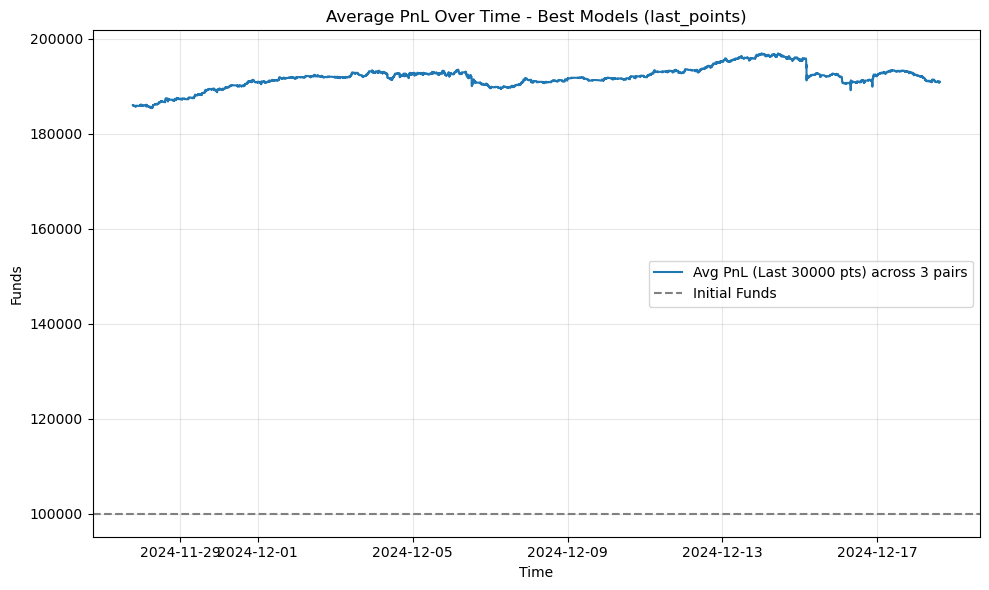

In [15]:
base_dir = "./processed"
data_folder = "./data"

process_all_folders(
    base_dir=base_dir,
    data_folder=data_folder,
    initial_funds=100000,
    points_per_day=1440,
    transaction_fee_rate=0.0003
)
